In [1]:
import wandb

wandb.init(project="test3", entity="xhradskyp")

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from torch.utils.data import random_split
from torchmetrics.functional import dice

In [2]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

net = UNET(3, 1)

In [3]:
def extract_blocks(images):
    count,M,N,ch = images.shape
    w, h = 64, 64
    new = np.empty((count*49, w, h, ch), dtype=np.uint8)
    i = 0
    for image in images:
        for j in range(7):
            for k in range(7):
                new[i] = image[k*32:(k+1)*64-k*32, j*32:(j+1)*64-j*32]
                i += 1
    return new

class MyDataset(Dataset):
    def __init__(self):
        images = np.load("data/images.npy")
        labels = np.load("data/labels.npy")
        
        images = extract_blocks(images)
        print("done")
        labels = extract_blocks(labels)
        print("done")
        labels = labels[..., 1]
        labels[labels >= 1] = 1
        print("done")
        
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        print(images.shape)
        self.images = images.permute((0, 3, 1, 2))
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [4]:
dataset = MyDataset()

done
done
done
torch.Size([244069, 64, 64, 3])


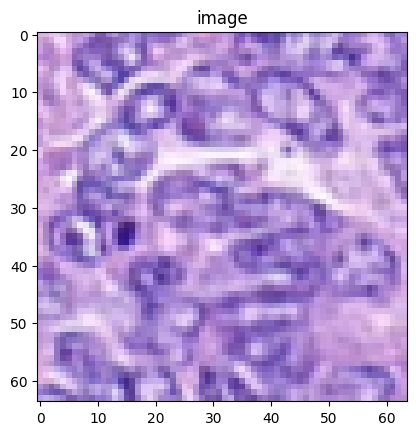

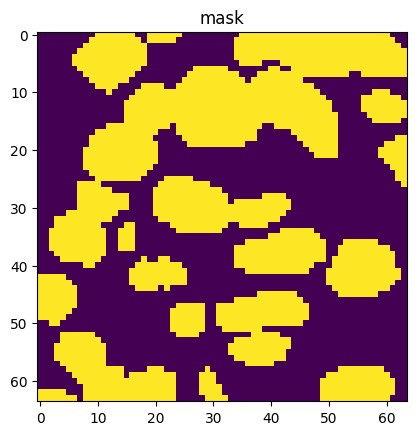

In [5]:
x = 123
plt.imshow(dataset[x][0].float().permute((1, 2, 0)).detach().numpy()/255)
plt.title("image")
plt.show()
plt.imshow(dataset[x][1].float().detach().numpy())
plt.title("mask")
plt.show()

In [6]:
train_data, test_data = random_split(dataset, [200000, 44069])
dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

In [12]:
num_epochs = 2
total_samples = len(train_data)
n_iterations = math.ceil(total_samples/64)
print(total_samples, n_iterations)
net = UNET(3, 1)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)

200000 3125


epoch 1/2, step 10/3125, loss 38.52052612304688, acc 0.43187353014945984, time 0:00:36.685329
epoch 1/2, step 20/3125, loss 41.78175163269043, acc 0.42081940174102783, time 0:01:07.908484
epoch 1/2, step 30/3125, loss 42.963789749145505, acc 0.4821452498435974, time 0:01:38.622572
epoch 1/2, step 40/3125, loss 42.27209320068359, acc 0.5057322978973389, time 0:02:13.965271
epoch 1/2, step 50/3125, loss 40.813280487060545, acc 0.5154310464859009, time 0:03:02.080575
epoch 1/2, step 60/3125, loss 40.45090522766113, acc 0.5078173279762268, time 0:03:39.334616
epoch 1/2, step 70/3125, loss 40.06822738647461, acc 0.5770756006240845, time 0:04:10.537001
epoch 1/2, step 80/3125, loss 38.59659423828125, acc 0.5477166771888733, time 0:04:41.961510
epoch 1/2, step 90/3125, loss 40.17683906555176, acc 0.5786465406417847, time 0:05:11.185819
epoch 1/2, step 100/3125, loss 41.352305221557614, acc 0.5618642568588257, time 0:05:40.543398


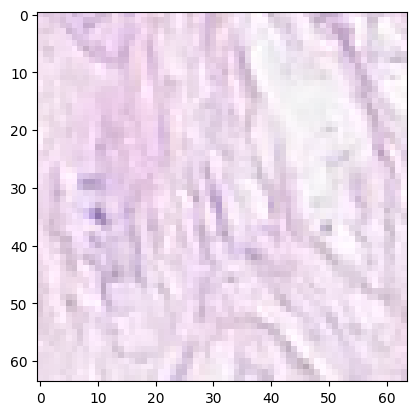

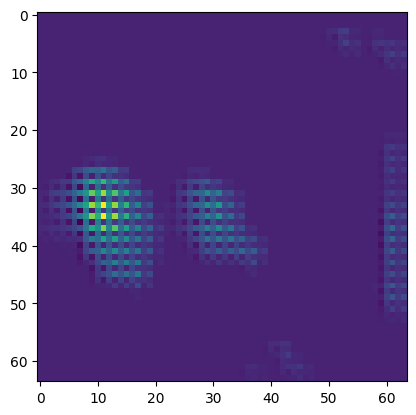

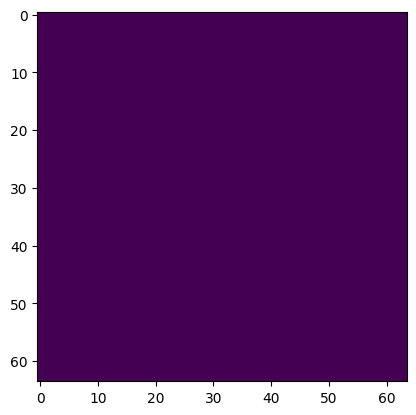

epoch 1/2, step 110/3125, loss 41.514285469055174, acc 0.5703336000442505, time 0:06:14.067758
epoch 1/2, step 120/3125, loss 38.61552619934082, acc 0.6142067909240723, time 0:06:45.484128
epoch 1/2, step 130/3125, loss 39.82604904174805, acc 0.6041907668113708, time 0:07:14.998732
epoch 1/2, step 140/3125, loss 39.23120613098145, acc 0.6382832527160645, time 0:07:43.374160
epoch 1/2, step 150/3125, loss 40.846130752563475, acc 0.6588809490203857, time 0:08:01.777942
epoch 1/2, step 160/3125, loss 38.24914970397949, acc 0.6551850438117981, time 0:08:21.256424
epoch 1/2, step 170/3125, loss 39.19378471374512, acc 0.6472863554954529, time 0:08:42.938068
epoch 1/2, step 180/3125, loss 39.7061466217041, acc 0.67515629529953, time 0:09:04.318204
epoch 1/2, step 190/3125, loss 37.212510681152345, acc 0.6656604409217834, time 0:09:23.584908
epoch 1/2, step 200/3125, loss 39.260214233398436, acc 0.6433906555175781, time 0:09:41.804724


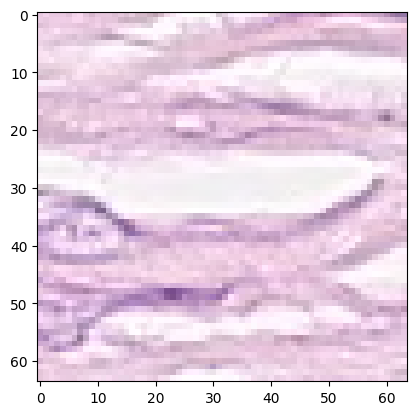

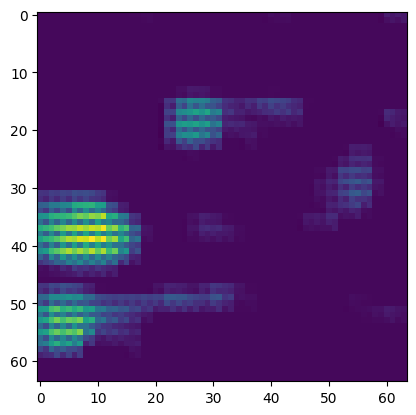

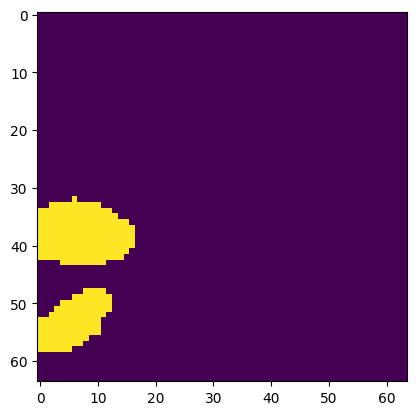

epoch 1/2, step 210/3125, loss 36.92760753631592, acc 0.6767786145210266, time 0:10:01.478902
epoch 1/2, step 220/3125, loss 40.32462921142578, acc 0.6174126267433167, time 0:10:20.349895
epoch 1/2, step 230/3125, loss 39.737571716308594, acc 0.6606894731521606, time 0:10:40.209723
epoch 1/2, step 240/3125, loss 39.25575256347656, acc 0.6306765079498291, time 0:11:02.269919
epoch 1/2, step 250/3125, loss 36.55809688568115, acc 0.6087075471878052, time 0:11:22.225102
epoch 1/2, step 260/3125, loss 37.13853759765625, acc 0.6323768496513367, time 0:11:41.165521
epoch 1/2, step 270/3125, loss 40.70542984008789, acc 0.626029908657074, time 0:12:01.292170
epoch 1/2, step 280/3125, loss 38.1033073425293, acc 0.6873797178268433, time 0:12:19.777760
epoch 1/2, step 290/3125, loss 36.40464706420899, acc 0.6543726921081543, time 0:12:40.440788
epoch 1/2, step 300/3125, loss 35.450422859191896, acc 0.6431726217269897, time 0:13:01.574495


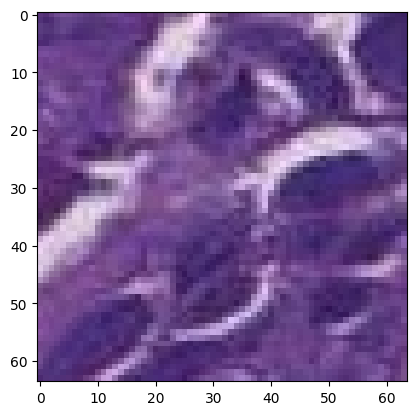

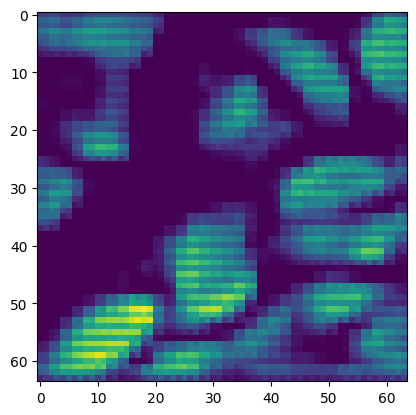

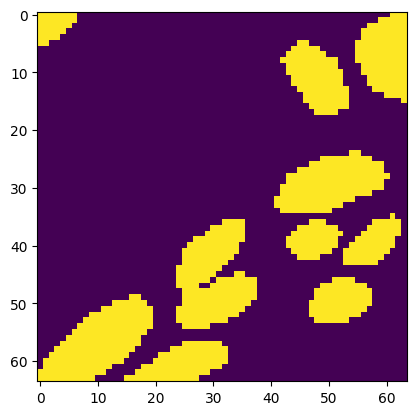

epoch 1/2, step 310/3125, loss 36.18350353240967, acc 0.636375367641449, time 0:13:22.632722
epoch 1/2, step 320/3125, loss 39.045365524291995, acc 0.6638519167900085, time 0:13:40.919715
epoch 1/2, step 330/3125, loss 36.44784393310547, acc 0.6790851354598999, time 0:14:00.602311
epoch 1/2, step 340/3125, loss 37.83134307861328, acc 0.6758331060409546, time 0:14:19.003187
epoch 1/2, step 350/3125, loss 35.29075622558594, acc 0.6328229308128357, time 0:14:38.949935
epoch 1/2, step 360/3125, loss 36.63285808563232, acc 0.684078574180603, time 0:14:57.956621
epoch 1/2, step 370/3125, loss 36.07493495941162, acc 0.6274421811103821, time 0:15:17.551465
epoch 1/2, step 380/3125, loss 37.79846267700195, acc 0.6359520554542542, time 0:15:37.471289
epoch 1/2, step 390/3125, loss 37.05322113037109, acc 0.6331397891044617, time 0:15:58.962845
epoch 1/2, step 400/3125, loss 35.823960876464845, acc 0.6242002248764038, time 0:16:17.911480


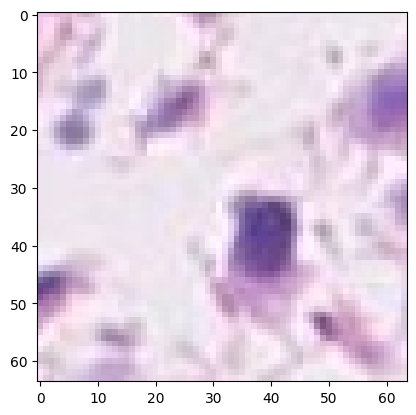

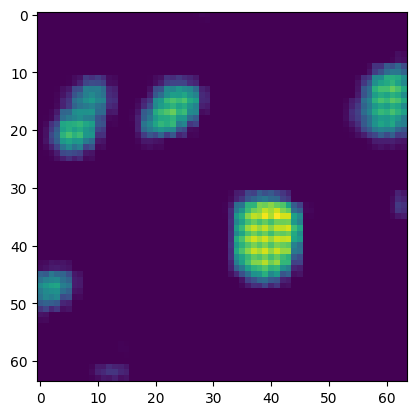

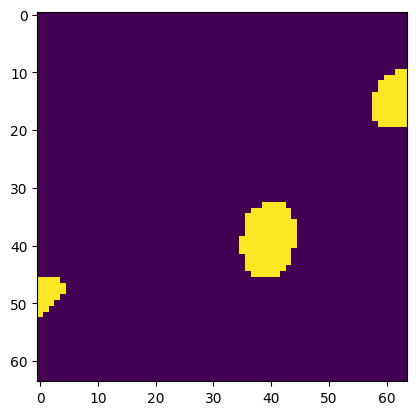

epoch 1/2, step 410/3125, loss 35.06739101409912, acc 0.5808353424072266, time 0:16:37.044158
epoch 1/2, step 420/3125, loss 36.02092018127441, acc 0.5908392071723938, time 0:16:56.323076
epoch 1/2, step 430/3125, loss 34.040761947631836, acc 0.6279942393302917, time 0:17:18.117638
epoch 1/2, step 440/3125, loss 35.260038185119626, acc 0.5943065881729126, time 0:17:39.447886
epoch 1/2, step 450/3125, loss 35.53667316436768, acc 0.6077867746353149, time 0:17:58.780244
epoch 1/2, step 460/3125, loss 35.43517227172852, acc 0.627238392829895, time 0:18:19.205179
epoch 1/2, step 470/3125, loss 35.33080978393555, acc 0.6313841342926025, time 0:18:42.655289
epoch 1/2, step 480/3125, loss 35.59707489013672, acc 0.5945842862129211, time 0:19:05.199054
epoch 1/2, step 490/3125, loss 34.752180671691896, acc 0.6130892038345337, time 0:19:25.076368
epoch 1/2, step 500/3125, loss 37.05177268981934, acc 0.6177220344543457, time 0:19:46.516240


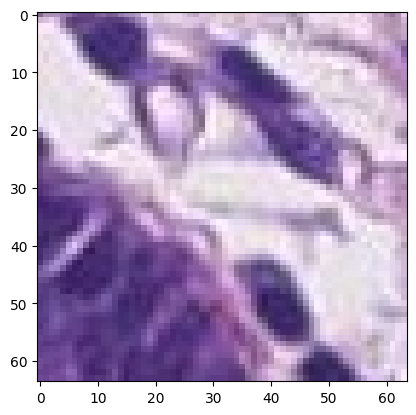

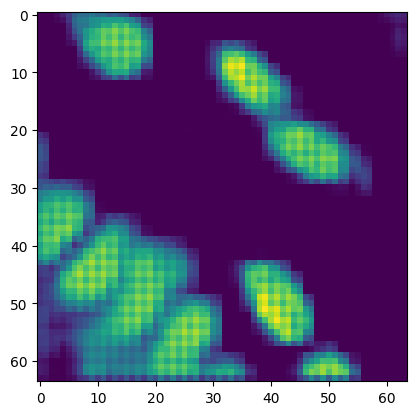

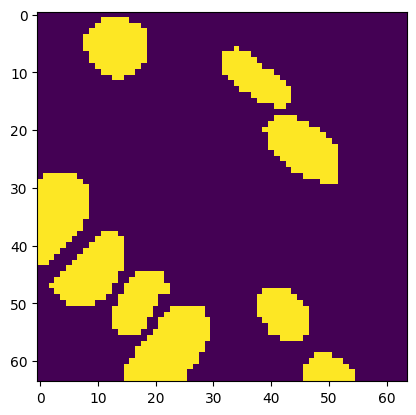

epoch 1/2, step 510/3125, loss 35.05607318878174, acc 0.6060318350791931, time 0:20:07.038429
epoch 1/2, step 520/3125, loss 34.688818740844724, acc 0.6007033586502075, time 0:20:27.006492
epoch 1/2, step 530/3125, loss 37.052190971374515, acc 0.57923424243927, time 0:20:44.606915
epoch 1/2, step 540/3125, loss 34.86653289794922, acc 0.588746190071106, time 0:21:03.116168
epoch 1/2, step 550/3125, loss 36.75435333251953, acc 0.6299964785575867, time 0:21:21.144909
epoch 1/2, step 560/3125, loss 35.221988677978516, acc 0.5383126139640808, time 0:21:39.188729
epoch 1/2, step 570/3125, loss 37.097952651977536, acc 0.5847066044807434, time 0:21:56.569665
epoch 1/2, step 580/3125, loss 34.73877143859863, acc 0.5308658480644226, time 0:22:14.078605
epoch 1/2, step 590/3125, loss 35.68653545379639, acc 0.5937074422836304, time 0:22:31.607616
epoch 1/2, step 600/3125, loss 32.59144115447998, acc 0.5522701144218445, time 0:22:48.673025


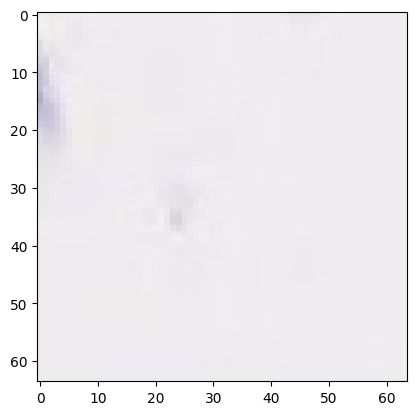

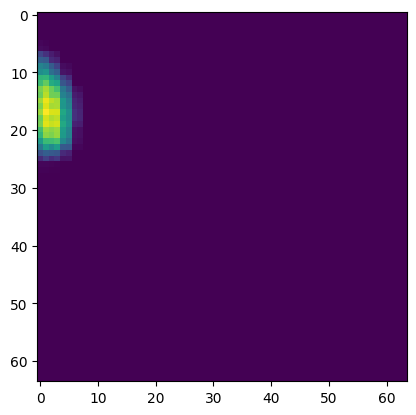

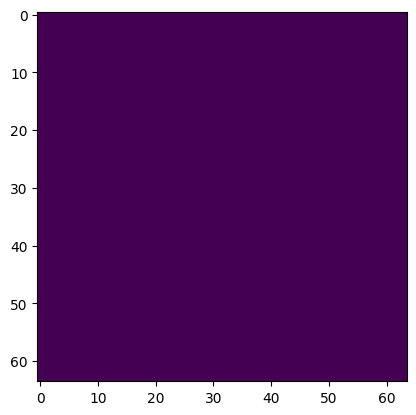

epoch 1/2, step 610/3125, loss 34.96950092315674, acc 0.5761078596115112, time 0:23:06.449506
epoch 1/2, step 620/3125, loss 36.21653442382812, acc 0.604663610458374, time 0:23:23.922278
epoch 1/2, step 630/3125, loss 35.209153938293454, acc 0.6187165379524231, time 0:23:40.950180
epoch 1/2, step 640/3125, loss 37.47790336608887, acc 0.6017998456954956, time 0:23:58.104735
epoch 1/2, step 650/3125, loss 36.138668060302734, acc 0.6045652031898499, time 0:24:15.865882
epoch 1/2, step 660/3125, loss 35.62311553955078, acc 0.5461612343788147, time 0:24:33.328634
epoch 1/2, step 670/3125, loss 37.652017784118655, acc 0.5927734971046448, time 0:24:51.128865
epoch 1/2, step 680/3125, loss 37.23473148345947, acc 0.5819426774978638, time 0:25:08.352229
epoch 1/2, step 690/3125, loss 34.754338073730466, acc 0.5835457444190979, time 0:25:26.252788
epoch 1/2, step 700/3125, loss 33.906789779663086, acc 0.5300970077514648, time 0:25:44.016992


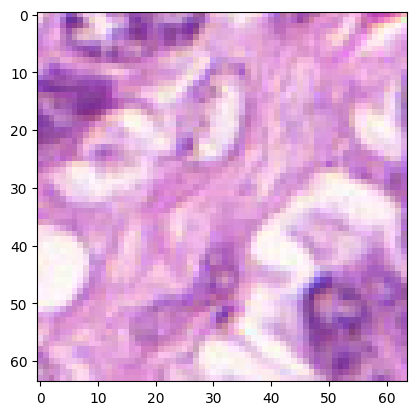

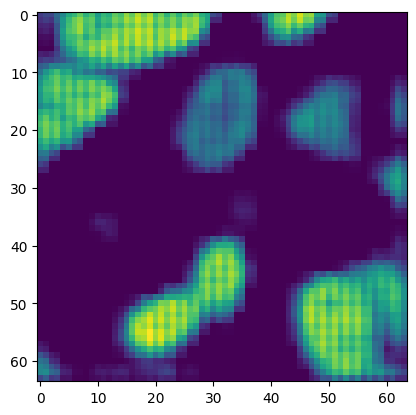

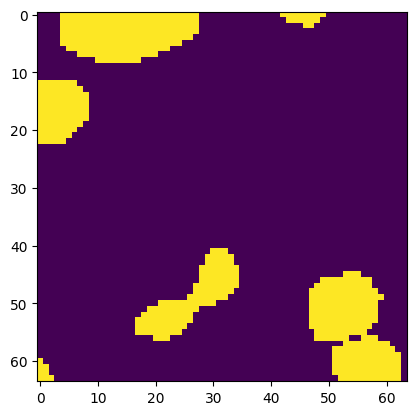

epoch 1/2, step 710/3125, loss 37.065562057495114, acc 0.5950745344161987, time 0:26:02.224474
epoch 1/2, step 720/3125, loss 35.91798477172851, acc 0.5758627653121948, time 0:26:19.490810
epoch 1/2, step 730/3125, loss 38.2074031829834, acc 0.5693070292472839, time 0:26:37.225870
epoch 1/2, step 740/3125, loss 34.125400352478025, acc 0.584358274936676, time 0:26:54.797573
epoch 1/2, step 750/3125, loss 34.41964454650879, acc 0.5800566077232361, time 0:27:13.232121
epoch 1/2, step 760/3125, loss 35.40101013183594, acc 0.5962250828742981, time 0:27:30.999078
epoch 1/2, step 770/3125, loss 34.958003997802734, acc 0.5507683157920837, time 0:27:48.909740
epoch 1/2, step 780/3125, loss 36.221764183044435, acc 0.5691345930099487, time 0:28:08.805764
epoch 1/2, step 790/3125, loss 34.90896205902099, acc 0.5549932718276978, time 0:28:28.806619
epoch 1/2, step 800/3125, loss 34.817647743225095, acc 0.5903817415237427, time 0:28:46.107241


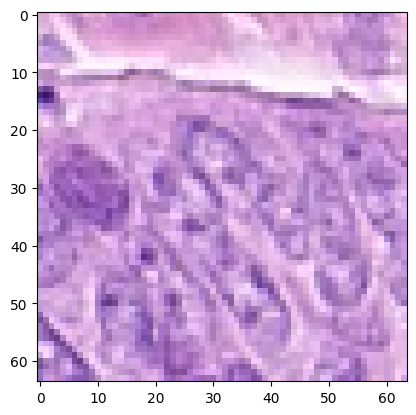

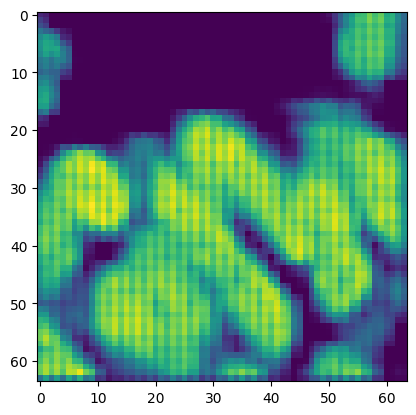

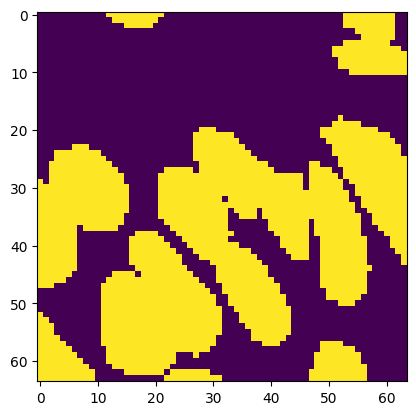

epoch 1/2, step 810/3125, loss 34.884758186340335, acc 0.564481794834137, time 0:29:04.039236
epoch 1/2, step 820/3125, loss 34.50337600708008, acc 0.5327397584915161, time 0:29:21.164076
epoch 1/2, step 830/3125, loss 36.448297309875485, acc 0.5618619918823242, time 0:29:39.125766
epoch 1/2, step 840/3125, loss 34.374556922912596, acc 0.5569483637809753, time 0:29:56.497479
epoch 1/2, step 850/3125, loss 32.58045330047607, acc 0.5597349405288696, time 0:30:13.882743
epoch 1/2, step 860/3125, loss 36.37551307678223, acc 0.5531256198883057, time 0:30:31.557545
epoch 1/2, step 870/3125, loss 37.6903190612793, acc 0.5852888226509094, time 0:30:49.072658
epoch 1/2, step 880/3125, loss 33.362643814086915, acc 0.5918288826942444, time 0:31:05.843974
epoch 1/2, step 890/3125, loss 34.65028762817383, acc 0.562810480594635, time 0:31:23.047969
epoch 1/2, step 900/3125, loss 36.18024044036865, acc 0.5562832951545715, time 0:31:40.387489


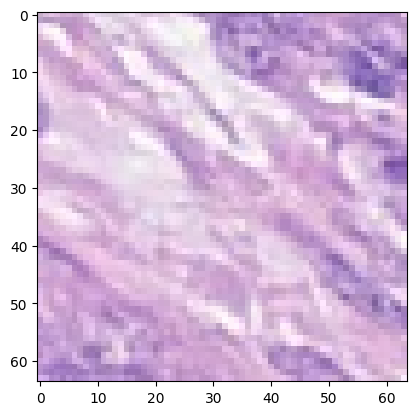

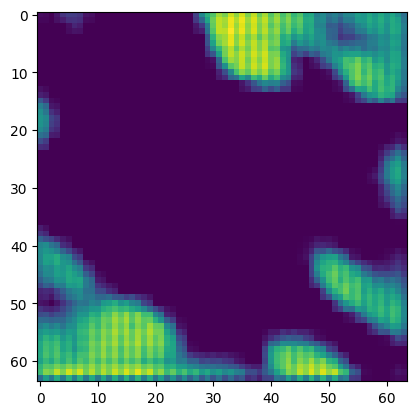

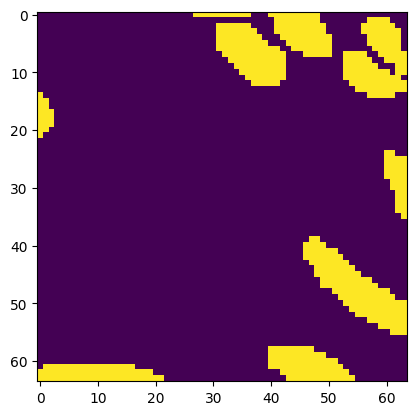

epoch 1/2, step 910/3125, loss 35.19534912109375, acc 0.5617408752441406, time 0:31:58.070561
epoch 1/2, step 920/3125, loss 34.21943874359131, acc 0.539542555809021, time 0:32:16.229101
epoch 1/2, step 930/3125, loss 35.807206344604495, acc 0.6066961884498596, time 0:32:34.573551
epoch 1/2, step 940/3125, loss 34.656459426879884, acc 0.5800100564956665, time 0:32:54.586530
epoch 1/2, step 950/3125, loss 34.9215389251709, acc 0.5377076268196106, time 0:33:14.984000
epoch 1/2, step 960/3125, loss 34.35306262969971, acc 0.5513050556182861, time 0:33:32.565801
epoch 1/2, step 970/3125, loss 34.50408725738525, acc 0.510953962802887, time 0:33:49.719636
epoch 1/2, step 980/3125, loss 35.49838008880615, acc 0.5494396686553955, time 0:34:07.624394
epoch 1/2, step 990/3125, loss 33.413434219360354, acc 0.5811256170272827, time 0:34:25.256579
epoch 1/2, step 1000/3125, loss 35.054107666015625, acc 0.5306470990180969, time 0:34:42.407450


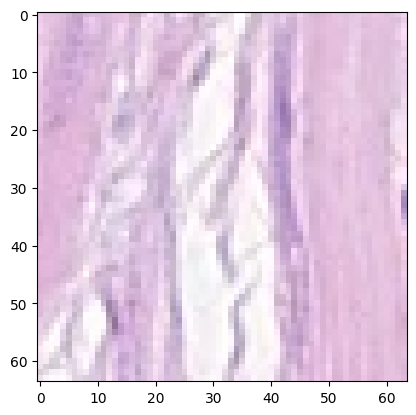

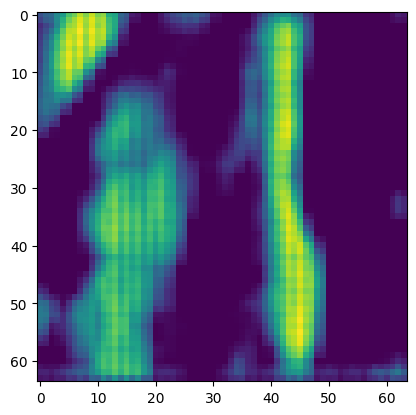

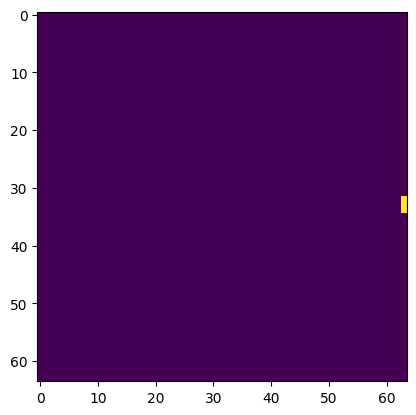

epoch 1/2, step 1010/3125, loss 34.41832733154297, acc 0.5392628312110901, time 0:34:59.931174
epoch 1/2, step 1020/3125, loss 33.42861137390137, acc 0.5417657494544983, time 0:35:17.437091
epoch 1/2, step 1030/3125, loss 34.013938903808594, acc 0.5815759301185608, time 0:35:34.102201
epoch 1/2, step 1040/3125, loss 36.50780773162842, acc 0.5260230302810669, time 0:35:51.229320
epoch 1/2, step 1050/3125, loss 36.00473251342773, acc 0.5258316993713379, time 0:36:08.792261
epoch 1/2, step 1060/3125, loss 35.683501434326175, acc 0.5273046493530273, time 0:36:25.388203
epoch 1/2, step 1070/3125, loss 33.756897354125975, acc 0.5461484789848328, time 0:36:42.768158
epoch 1/2, step 1080/3125, loss 34.072723388671875, acc 0.5804553627967834, time 0:36:59.867742
epoch 1/2, step 1090/3125, loss 34.862178802490234, acc 0.5645355582237244, time 0:37:17.187930
epoch 1/2, step 1100/3125, loss 34.076376342773436, acc 0.5702343583106995, time 0:37:33.791722


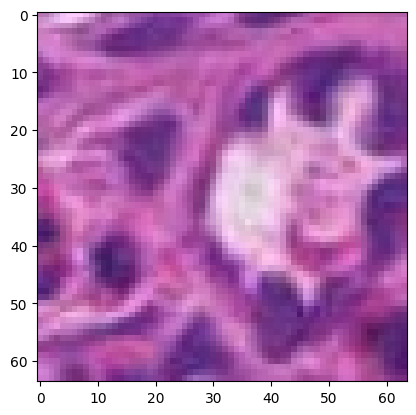

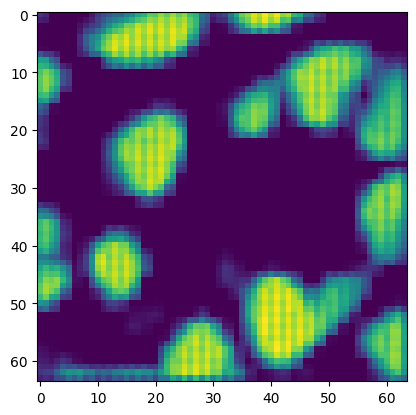

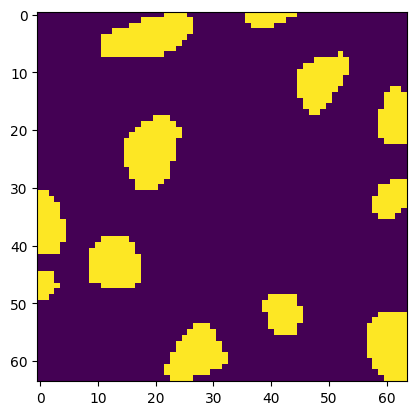

epoch 1/2, step 1110/3125, loss 36.8878978729248, acc 0.5060128569602966, time 0:37:51.560707
epoch 1/2, step 1120/3125, loss 36.745591926574704, acc 0.493872731924057, time 0:38:09.323370
epoch 1/2, step 1130/3125, loss 34.002486610412596, acc 0.531913161277771, time 0:38:26.170680
epoch 1/2, step 1140/3125, loss 35.766083526611325, acc 0.5317025184631348, time 0:38:43.021252
epoch 1/2, step 1150/3125, loss 36.16181812286377, acc 0.5359744429588318, time 0:39:00.059611
epoch 1/2, step 1160/3125, loss 35.09919605255127, acc 0.5348868370056152, time 0:39:17.048817
epoch 1/2, step 1170/3125, loss 34.58461170196533, acc 0.5343462228775024, time 0:39:33.980714
epoch 1/2, step 1180/3125, loss 32.99579372406006, acc 0.5404980778694153, time 0:39:50.607847
epoch 1/2, step 1190/3125, loss 34.201018714904784, acc 0.5536482334136963, time 0:40:07.170171
epoch 1/2, step 1200/3125, loss 34.676327514648435, acc 0.5141804814338684, time 0:40:24.256019


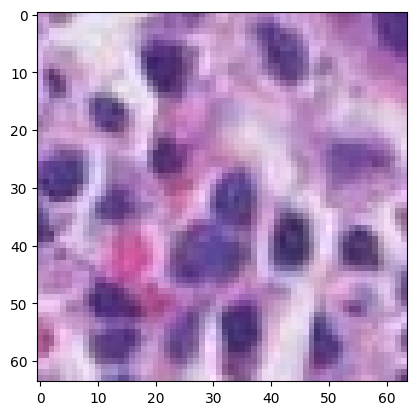

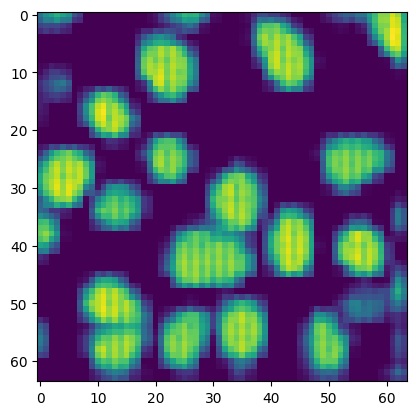

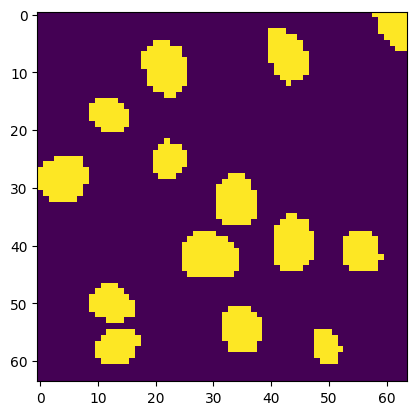

epoch 1/2, step 1210/3125, loss 33.96059989929199, acc 0.5307519435882568, time 0:40:42.148829
epoch 1/2, step 1220/3125, loss 33.36744365692139, acc 0.5288601517677307, time 0:40:59.715923
epoch 1/2, step 1230/3125, loss 32.98298645019531, acc 0.5404734015464783, time 0:41:16.034812
epoch 1/2, step 1240/3125, loss 34.02012939453125, acc 0.5559739470481873, time 0:41:33.268366
epoch 1/2, step 1250/3125, loss 35.04946365356445, acc 0.5268332958221436, time 0:41:50.297800
epoch 1/2, step 1260/3125, loss 36.57190284729004, acc 0.5232007503509521, time 0:42:06.500018
epoch 1/2, step 1270/3125, loss 35.18859024047852, acc 0.5013251304626465, time 0:42:23.732450
epoch 1/2, step 1280/3125, loss 35.018951416015625, acc 0.5031517148017883, time 0:42:40.074883
epoch 1/2, step 1290/3125, loss 38.618988800048825, acc 0.5724363327026367, time 0:42:56.855688
epoch 1/2, step 1300/3125, loss 34.70986385345459, acc 0.586182177066803, time 0:43:13.937084


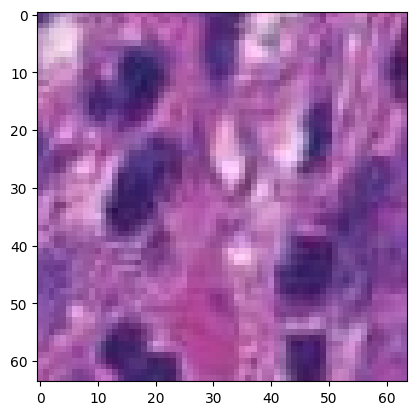

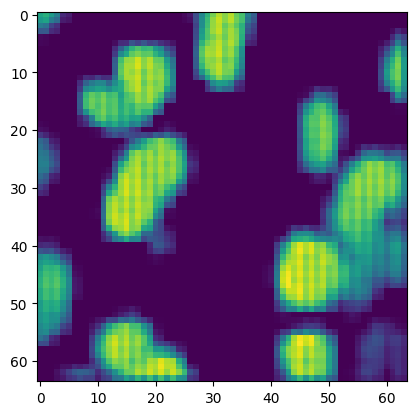

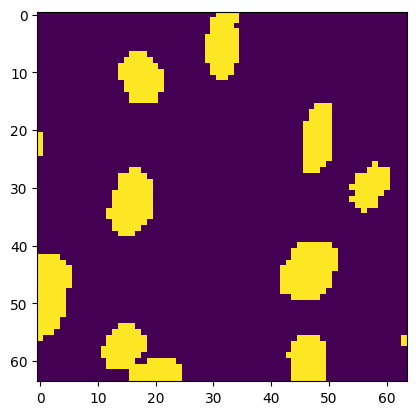

epoch 1/2, step 1310/3125, loss 35.57716255187988, acc 0.5315789580345154, time 0:43:31.269393
epoch 1/2, step 1320/3125, loss 34.38700828552246, acc 0.557885468006134, time 0:43:48.359949
epoch 1/2, step 1330/3125, loss 33.41806049346924, acc 0.5076581239700317, time 0:44:04.628508
epoch 1/2, step 1340/3125, loss 35.7709457397461, acc 0.5308659076690674, time 0:44:23.627524
epoch 1/2, step 1350/3125, loss 36.68980712890625, acc 0.5712950825691223, time 0:44:43.045872
epoch 1/2, step 1360/3125, loss 34.038065910339355, acc 0.5008837580680847, time 0:45:00.307165
epoch 1/2, step 1370/3125, loss 34.921041107177736, acc 0.48385000228881836, time 0:45:17.835433
epoch 1/2, step 1380/3125, loss 34.874380111694336, acc 0.4851985275745392, time 0:45:35.135942
epoch 1/2, step 1390/3125, loss 33.90757007598877, acc 0.5649099946022034, time 0:45:52.172775
epoch 1/2, step 1400/3125, loss 35.87217426300049, acc 0.4853089153766632, time 0:46:09.469365


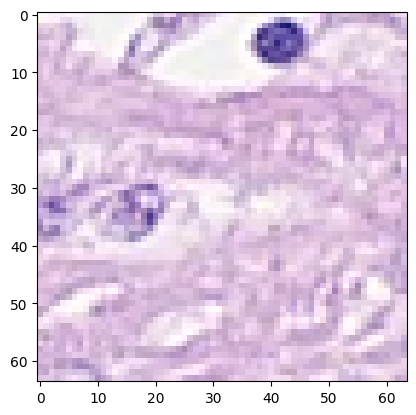

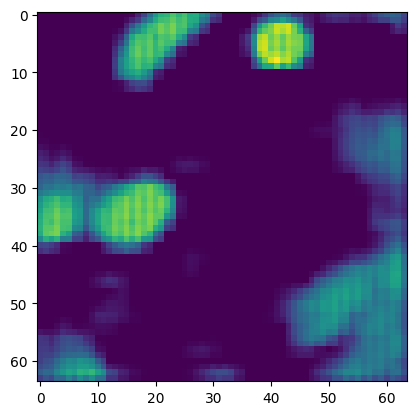

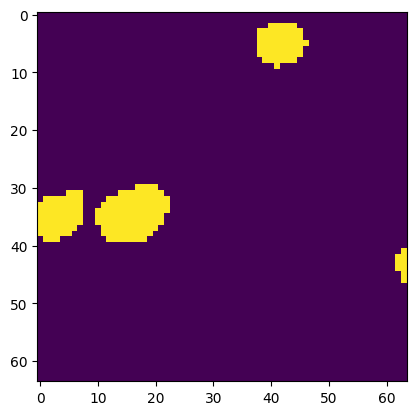

epoch 1/2, step 1410/3125, loss 36.03522777557373, acc 0.4763004183769226, time 0:46:26.808792
epoch 1/2, step 1420/3125, loss 34.01272678375244, acc 0.4777071177959442, time 0:46:43.228232
epoch 1/2, step 1430/3125, loss 34.65260467529297, acc 0.46878987550735474, time 0:47:00.275433
epoch 1/2, step 1440/3125, loss 35.234472846984865, acc 0.49156367778778076, time 0:47:17.164437
epoch 1/2, step 1450/3125, loss 33.382564544677734, acc 0.5415417551994324, time 0:47:34.104075
epoch 1/2, step 1460/3125, loss 33.57093143463135, acc 0.5186882615089417, time 0:47:51.496902
epoch 1/2, step 1470/3125, loss 34.436557579040525, acc 0.4698062837123871, time 0:48:07.986756
epoch 1/2, step 1480/3125, loss 35.00438270568848, acc 0.5453245639801025, time 0:48:24.966191
epoch 1/2, step 1490/3125, loss 35.39253387451172, acc 0.5085305571556091, time 0:48:41.885078
epoch 1/2, step 1500/3125, loss 34.41364688873291, acc 0.4373166561126709, time 0:48:58.211867


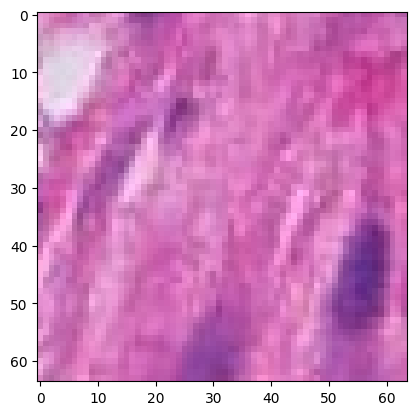

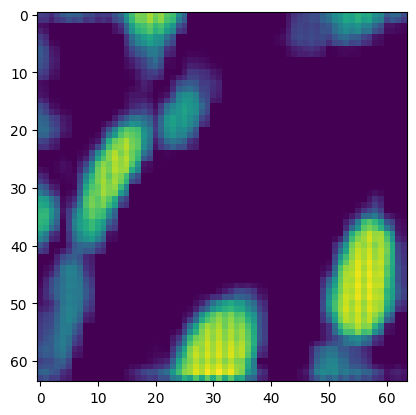

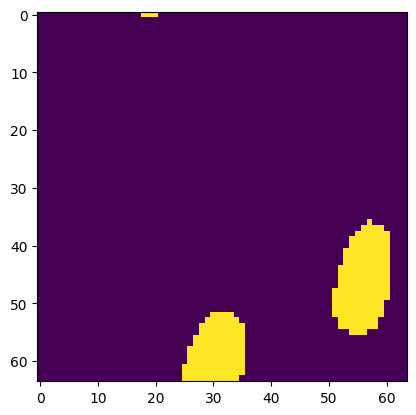

epoch 1/2, step 1510/3125, loss 35.665890502929685, acc 0.5324029326438904, time 0:49:15.692692
epoch 1/2, step 1520/3125, loss 34.31913051605225, acc 0.5187124609947205, time 0:49:32.994380
epoch 1/2, step 1530/3125, loss 33.55447540283203, acc 0.484224796295166, time 0:49:49.953440
epoch 1/2, step 1540/3125, loss 35.631909942626955, acc 0.5315850973129272, time 0:50:06.711373
epoch 1/2, step 1550/3125, loss 34.629685974121095, acc 0.4935273826122284, time 0:50:23.089011
epoch 1/2, step 1560/3125, loss 34.74193515777588, acc 0.46880626678466797, time 0:50:40.231754
epoch 1/2, step 1570/3125, loss 37.025748825073244, acc 0.4556029438972473, time 0:50:56.997261
epoch 1/2, step 1580/3125, loss 33.83417148590088, acc 0.4973699450492859, time 0:51:13.625038
epoch 1/2, step 1590/3125, loss 36.38370609283447, acc 0.49563321471214294, time 0:51:30.475996
epoch 1/2, step 1600/3125, loss 36.6363000869751, acc 0.5388674139976501, time 0:51:47.535545


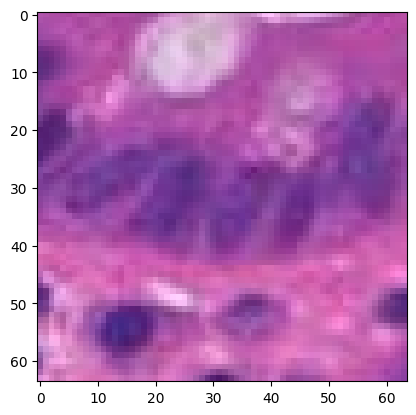

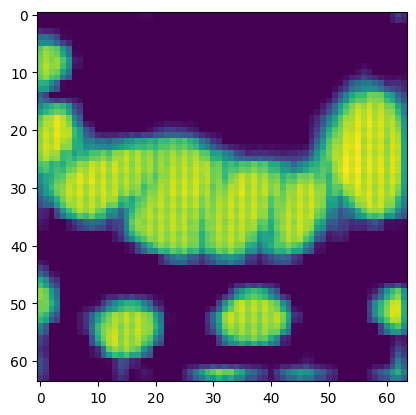

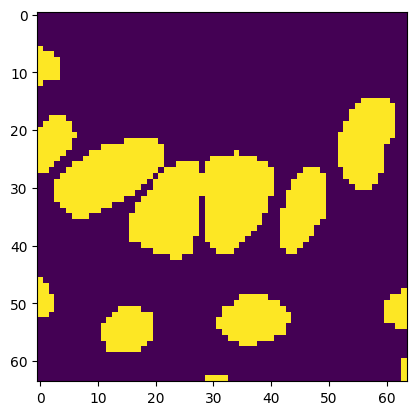

epoch 1/2, step 1610/3125, loss 35.46019802093506, acc 0.5555332899093628, time 0:52:04.174205
epoch 1/2, step 1620/3125, loss 34.27747478485107, acc 0.49084338545799255, time 0:52:21.141959
epoch 1/2, step 1630/3125, loss 34.39317245483399, acc 0.5278647541999817, time 0:52:38.058197
epoch 1/2, step 1640/3125, loss 36.67847385406494, acc 0.5486709475517273, time 0:52:54.460400
epoch 1/2, step 1650/3125, loss 32.30832176208496, acc 0.4801121652126312, time 0:53:11.638413
epoch 1/2, step 1660/3125, loss 35.34095096588135, acc 0.472896546125412, time 0:53:28.151097
epoch 1/2, step 1670/3125, loss 33.177859497070315, acc 0.5604127049446106, time 0:53:44.745971
epoch 1/2, step 1680/3125, loss 33.58218231201172, acc 0.5420809984207153, time 0:54:01.536492
epoch 1/2, step 1690/3125, loss 34.566104125976565, acc 0.4570930004119873, time 0:54:17.881845
epoch 1/2, step 1700/3125, loss 32.747083854675296, acc 0.48517903685569763, time 0:54:35.102208


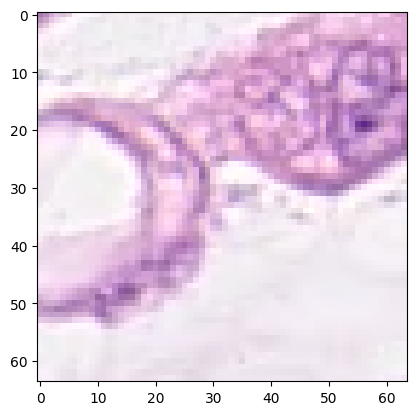

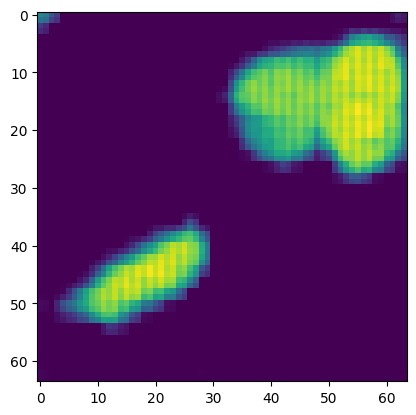

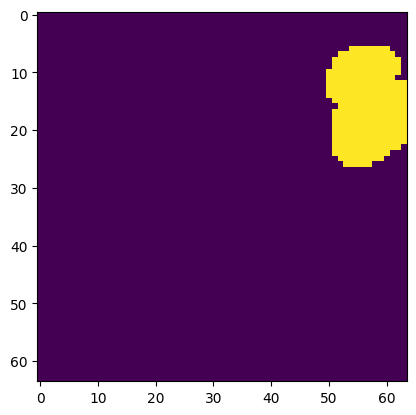

epoch 1/2, step 1710/3125, loss 36.07657642364502, acc 0.47323161363601685, time 0:54:52.486029
epoch 1/2, step 1720/3125, loss 33.410799217224124, acc 0.5324423313140869, time 0:55:09.930548
epoch 1/2, step 1730/3125, loss 34.289102935791014, acc 0.5517438650131226, time 0:55:26.511326
epoch 1/2, step 1740/3125, loss 33.92054748535156, acc 0.4760286211967468, time 0:55:43.842209
epoch 1/2, step 1750/3125, loss 36.241227340698245, acc 0.5011950731277466, time 0:56:00.431799
epoch 1/2, step 1760/3125, loss 35.491641235351565, acc 0.5027685761451721, time 0:56:17.140714
epoch 1/2, step 1770/3125, loss 34.14848175048828, acc 0.4469248354434967, time 0:56:33.306213
epoch 1/2, step 1780/3125, loss 34.1390302658081, acc 0.4559369385242462, time 0:56:49.480119
epoch 1/2, step 1790/3125, loss 34.22420444488525, acc 0.5101026296615601, time 0:57:06.450799
epoch 1/2, step 1800/3125, loss 35.56974563598633, acc 0.5158151984214783, time 0:57:23.032981


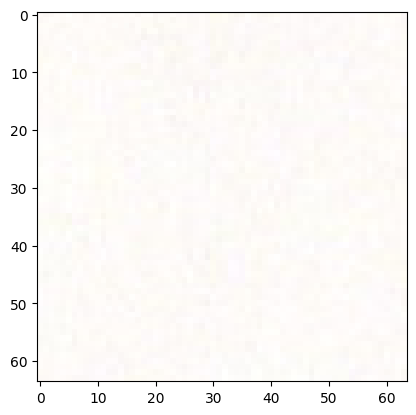

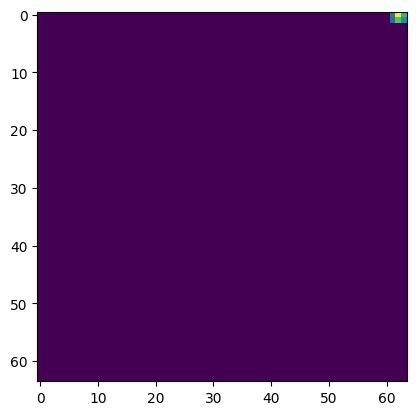

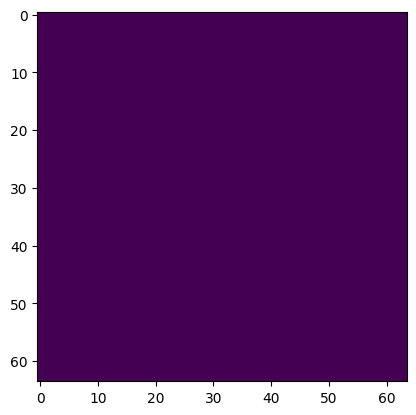

epoch 1/2, step 1810/3125, loss 35.37269554138184, acc 0.501690149307251, time 0:57:40.219223
epoch 1/2, step 1820/3125, loss 37.28813934326172, acc 0.5242546200752258, time 0:57:56.880235
epoch 1/2, step 1830/3125, loss 34.66562919616699, acc 0.5343976616859436, time 0:58:13.662672
epoch 1/2, step 1840/3125, loss 33.1605188369751, acc 0.5027655363082886, time 0:58:30.657944
epoch 1/2, step 1850/3125, loss 33.91020259857178, acc 0.5034787654876709, time 0:58:47.426650
epoch 1/2, step 1860/3125, loss 32.14666900634766, acc 0.5131658315658569, time 0:59:03.963343
epoch 1/2, step 1870/3125, loss 35.54625129699707, acc 0.5164945125579834, time 0:59:20.668823
epoch 1/2, step 1880/3125, loss 33.504689407348636, acc 0.49713101983070374, time 0:59:37.373220
epoch 1/2, step 1890/3125, loss 34.529062843322755, acc 0.5421554446220398, time 0:59:53.804287
epoch 1/2, step 1900/3125, loss 35.93483695983887, acc 0.5470777750015259, time 1:00:10.249748


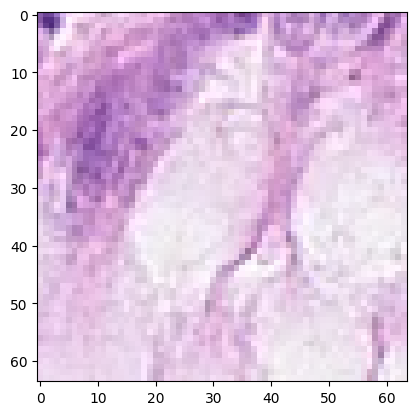

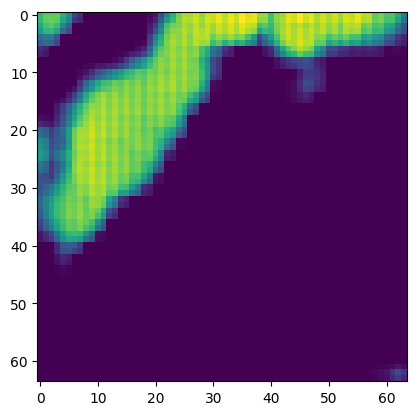

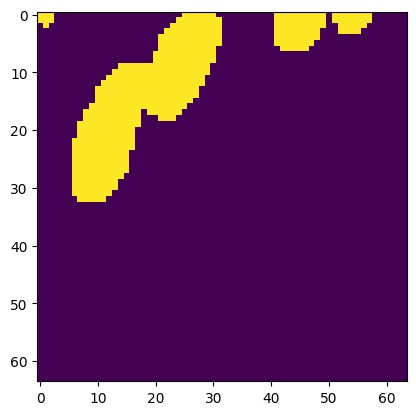

epoch 1/2, step 1910/3125, loss 33.75478744506836, acc 0.5545076131820679, time 1:00:28.446206
epoch 1/2, step 1920/3125, loss 34.45255680084229, acc 0.5197343230247498, time 1:00:44.866266
epoch 1/2, step 1930/3125, loss 33.96672019958496, acc 0.4239620268344879, time 1:01:02.509236
epoch 1/2, step 1940/3125, loss 33.807936668395996, acc 0.5760701298713684, time 1:01:22.640728
epoch 1/2, step 1950/3125, loss 36.565016174316405, acc 0.5091415047645569, time 1:01:40.989150
epoch 1/2, step 1960/3125, loss 35.51786651611328, acc 0.5246293544769287, time 1:01:57.529730
epoch 1/2, step 1970/3125, loss 34.98610725402832, acc 0.5287525653839111, time 1:02:14.185770
epoch 1/2, step 1980/3125, loss 35.20146179199219, acc 0.49923574924468994, time 1:02:31.077350
epoch 1/2, step 1990/3125, loss 34.40609474182129, acc 0.4861120283603668, time 1:02:48.440028
epoch 1/2, step 2000/3125, loss 33.6844259262085, acc 0.4667434096336365, time 1:03:05.514285


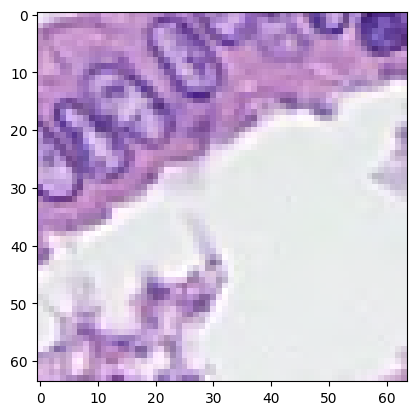

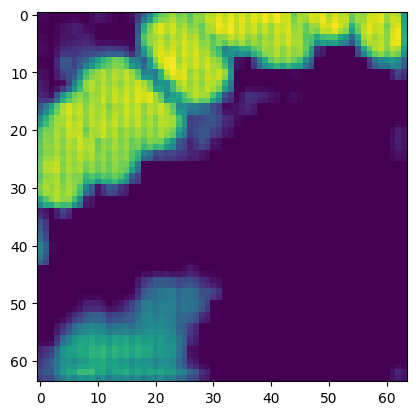

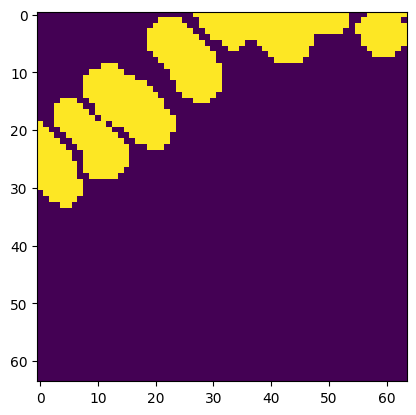

epoch 1/2, step 2010/3125, loss 36.464912796020506, acc 0.5159901976585388, time 1:03:23.082355
epoch 1/2, step 2020/3125, loss 34.06859951019287, acc 0.4717268943786621, time 1:03:40.312123
epoch 1/2, step 2030/3125, loss 34.13249588012695, acc 0.46610885858535767, time 1:03:57.286689
epoch 1/2, step 2040/3125, loss 34.53237247467041, acc 0.510398805141449, time 1:04:14.142370
epoch 1/2, step 2050/3125, loss 34.07956466674805, acc 0.5276229381561279, time 1:04:31.538550
epoch 1/2, step 2060/3125, loss 34.71725845336914, acc 0.5043696761131287, time 1:04:48.946618
epoch 1/2, step 2070/3125, loss 35.28242111206055, acc 0.5415840744972229, time 1:05:05.019629
epoch 1/2, step 2080/3125, loss 36.29793796539307, acc 0.483529657125473, time 1:05:22.237935
epoch 1/2, step 2090/3125, loss 32.86055088043213, acc 0.48533615469932556, time 1:05:38.454407
epoch 1/2, step 2100/3125, loss 34.40125770568848, acc 0.5290668606758118, time 1:05:55.174717


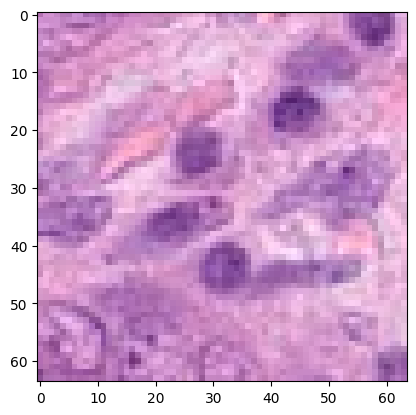

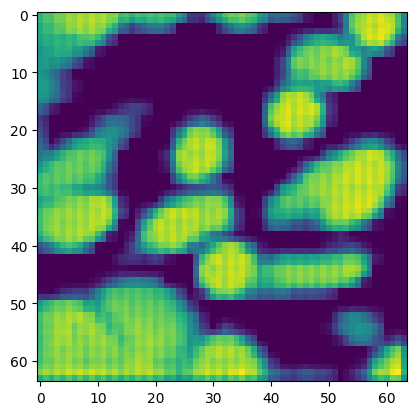

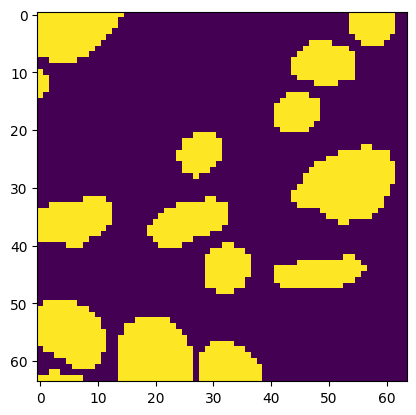

epoch 1/2, step 2110/3125, loss 35.993140029907224, acc 0.5215035676956177, time 1:06:12.308023
epoch 1/2, step 2120/3125, loss 33.57926445007324, acc 0.48938387632369995, time 1:06:31.482076
epoch 1/2, step 2130/3125, loss 34.60544605255127, acc 0.43538108468055725, time 1:06:48.841688
epoch 1/2, step 2140/3125, loss 35.202689743041994, acc 0.5180143713951111, time 1:07:05.332842
epoch 1/2, step 2150/3125, loss 34.769003295898436, acc 0.4949256181716919, time 1:07:22.466900
epoch 1/2, step 2160/3125, loss 34.562350273132324, acc 0.43799442052841187, time 1:07:39.715135
epoch 1/2, step 2170/3125, loss 34.94801406860351, acc 0.5014227032661438, time 1:07:55.769744
epoch 1/2, step 2180/3125, loss 33.29669876098633, acc 0.5326684713363647, time 1:08:12.857148
epoch 1/2, step 2190/3125, loss 33.410949325561525, acc 0.4980689585208893, time 1:08:29.351439
epoch 1/2, step 2200/3125, loss 34.173421669006345, acc 0.49971720576286316, time 1:08:46.423415


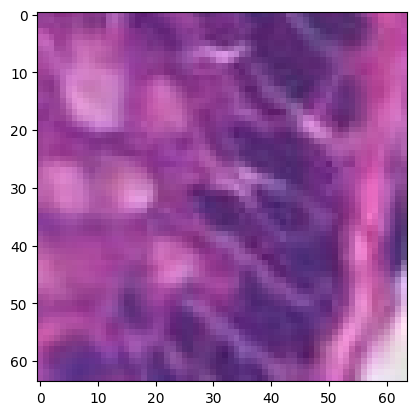

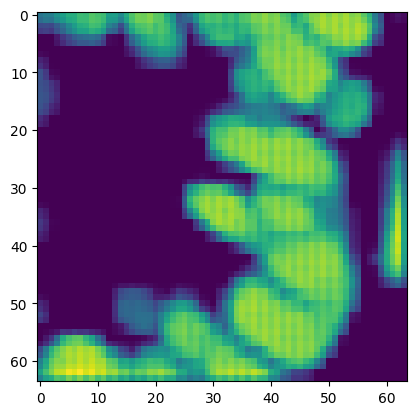

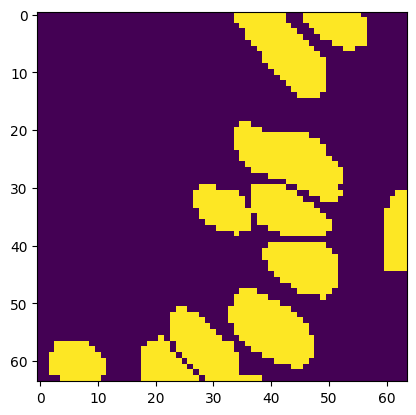

epoch 1/2, step 2210/3125, loss 35.98022346496582, acc 0.4999672472476959, time 1:09:04.174310
epoch 1/2, step 2220/3125, loss 33.110016632080075, acc 0.48722437024116516, time 1:09:21.446225
epoch 1/2, step 2230/3125, loss 32.50908145904541, acc 0.4980050325393677, time 1:09:37.754158
epoch 1/2, step 2240/3125, loss 33.28600730895996, acc 0.5054293274879456, time 1:09:54.654197
epoch 1/2, step 2250/3125, loss 35.349799728393556, acc 0.4617154002189636, time 1:10:11.167564
epoch 1/2, step 2260/3125, loss 34.05795745849609, acc 0.4786500632762909, time 1:10:27.955532
epoch 1/2, step 2270/3125, loss 33.859199905395506, acc 0.5293859243392944, time 1:10:45.216340
epoch 1/2, step 2280/3125, loss 34.3135326385498, acc 0.48661524057388306, time 1:11:02.221249
epoch 1/2, step 2290/3125, loss 34.714144706726074, acc 0.4406847655773163, time 1:11:18.948357
epoch 1/2, step 2300/3125, loss 33.69614925384521, acc 0.49321189522743225, time 1:11:35.737700


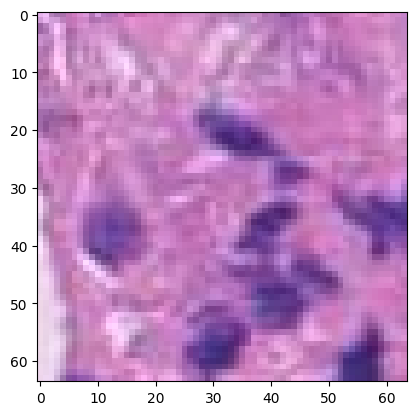

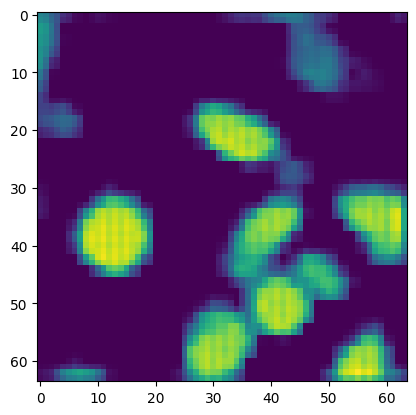

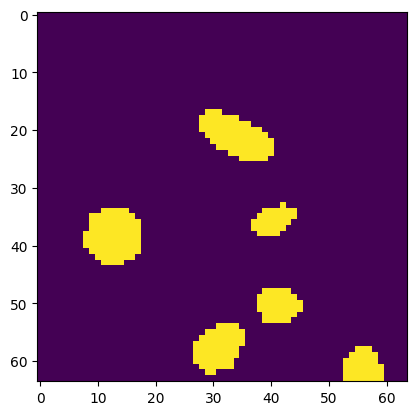

epoch 1/2, step 2310/3125, loss 33.878532600402835, acc 0.4894462525844574, time 1:11:52.771980
epoch 1/2, step 2320/3125, loss 33.88518886566162, acc 0.48779648542404175, time 1:12:09.300149
epoch 1/2, step 2330/3125, loss 33.71553821563721, acc 0.5156529545783997, time 1:12:26.042125
epoch 1/2, step 2340/3125, loss 33.538500022888186, acc 0.46244022250175476, time 1:12:42.625210
epoch 1/2, step 2350/3125, loss 34.22362728118897, acc 0.5352281928062439, time 1:12:59.954181
epoch 1/2, step 2360/3125, loss 36.05231285095215, acc 0.520028293132782, time 1:13:16.653442
epoch 1/2, step 2370/3125, loss 34.546797370910646, acc 0.47532063722610474, time 1:13:33.271098
epoch 1/2, step 2380/3125, loss 35.74919185638428, acc 0.4887484610080719, time 1:13:49.724883
epoch 1/2, step 2390/3125, loss 33.67966804504395, acc 0.5084571838378906, time 1:14:06.535781
epoch 1/2, step 2400/3125, loss 33.35233097076416, acc 0.45514875650405884, time 1:14:22.830870


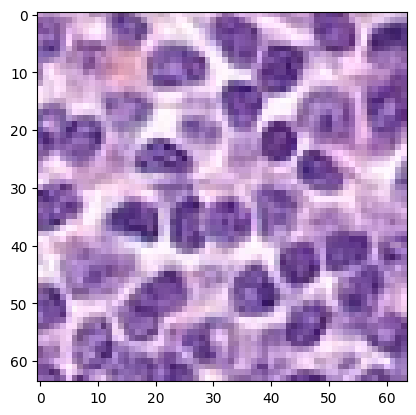

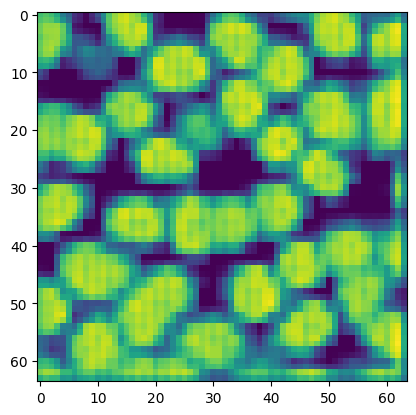

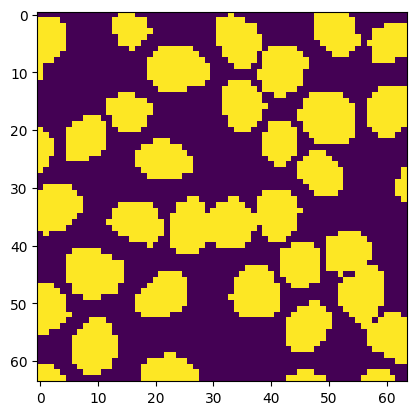

epoch 1/2, step 2410/3125, loss 33.20983352661133, acc 0.5042505264282227, time 1:14:40.858879
epoch 1/2, step 2420/3125, loss 34.408867835998535, acc 0.4828002452850342, time 1:14:57.185224
epoch 1/2, step 2430/3125, loss 34.57484188079834, acc 0.5020062923431396, time 1:15:13.859524
epoch 1/2, step 2440/3125, loss 34.06710510253906, acc 0.5166213512420654, time 1:15:30.563582
epoch 1/2, step 2450/3125, loss 33.99003601074219, acc 0.4569338262081146, time 1:15:47.555997
epoch 1/2, step 2460/3125, loss 34.92691783905029, acc 0.5277618169784546, time 1:16:03.742052
epoch 1/2, step 2470/3125, loss 35.43055019378662, acc 0.5098984837532043, time 1:16:20.025575
epoch 1/2, step 2480/3125, loss 35.98891983032227, acc 0.5454752445220947, time 1:16:37.149804
epoch 1/2, step 2490/3125, loss 32.798708152771, acc 0.4847484827041626, time 1:16:53.532349
epoch 1/2, step 2500/3125, loss 34.86196308135986, acc 0.5140947103500366, time 1:17:09.965857


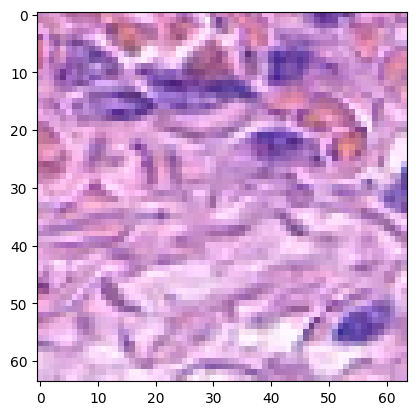

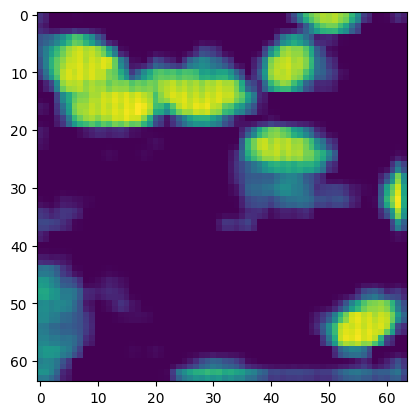

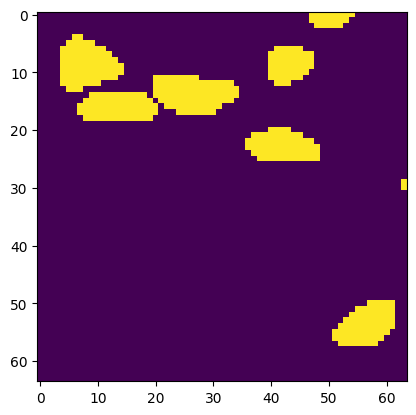

epoch 1/2, step 2510/3125, loss 33.61141223907471, acc 0.46012088656425476, time 1:17:27.592735
epoch 1/2, step 2520/3125, loss 33.90524616241455, acc 0.4629063010215759, time 1:17:44.229326
epoch 1/2, step 2530/3125, loss 34.40783576965332, acc 0.4647461771965027, time 1:18:01.206201
epoch 1/2, step 2540/3125, loss 33.20461635589599, acc 0.5001196265220642, time 1:18:18.158774
epoch 1/2, step 2550/3125, loss 32.46612968444824, acc 0.4711998701095581, time 1:18:34.627682
epoch 1/2, step 2560/3125, loss 34.66396827697754, acc 0.5256465077400208, time 1:18:51.432093
epoch 1/2, step 2570/3125, loss 34.44578895568848, acc 0.5050802826881409, time 1:19:08.893793
epoch 1/2, step 2580/3125, loss 34.851772689819335, acc 0.5055882930755615, time 1:19:25.391719
epoch 1/2, step 2590/3125, loss 33.876794052124026, acc 0.5017936825752258, time 1:19:42.436515
epoch 1/2, step 2600/3125, loss 35.24071922302246, acc 0.462358295917511, time 1:19:59.063112


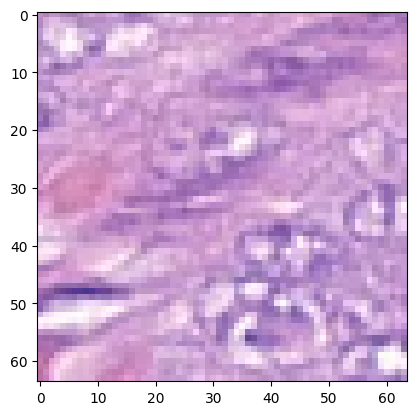

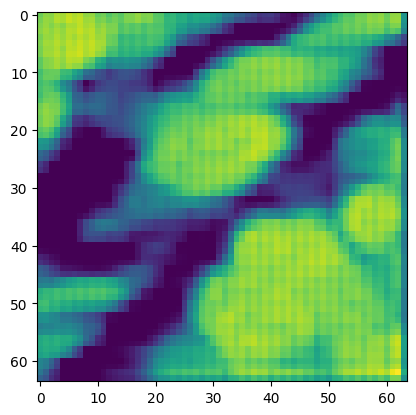

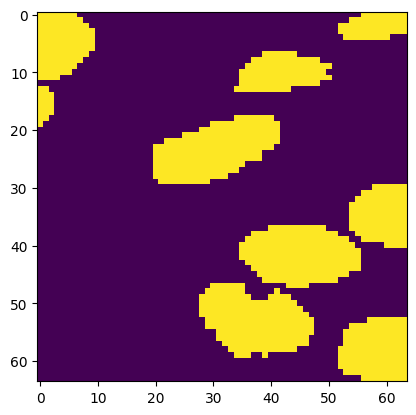

epoch 1/2, step 2610/3125, loss 34.78726673126221, acc 0.4584849178791046, time 1:20:16.296106
epoch 1/2, step 2620/3125, loss 35.579878616333005, acc 0.5220456123352051, time 1:20:32.624010
epoch 1/2, step 2630/3125, loss 34.69013919830322, acc 0.5204927921295166, time 1:20:50.377201
epoch 1/2, step 2640/3125, loss 34.28976287841797, acc 0.4475015103816986, time 1:21:07.423205
epoch 1/2, step 2650/3125, loss 34.55520477294922, acc 0.48500922322273254, time 1:21:24.139331
epoch 1/2, step 2660/3125, loss 33.643293380737305, acc 0.5523222088813782, time 1:21:41.148659
epoch 1/2, step 2670/3125, loss 34.24301986694336, acc 0.5510398149490356, time 1:21:58.350086
epoch 1/2, step 2680/3125, loss 33.629635620117185, acc 0.45730456709861755, time 1:22:14.663101
epoch 1/2, step 2690/3125, loss 33.34141521453857, acc 0.4554567039012909, time 1:22:30.917063
epoch 1/2, step 2700/3125, loss 33.10561275482178, acc 0.4841456413269043, time 1:22:47.422955


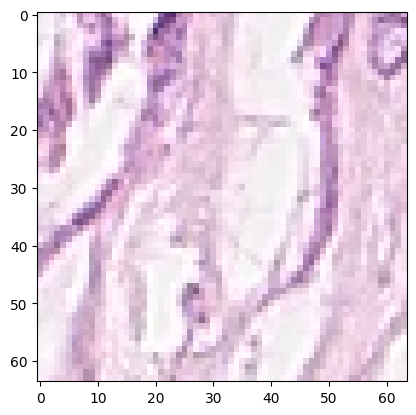

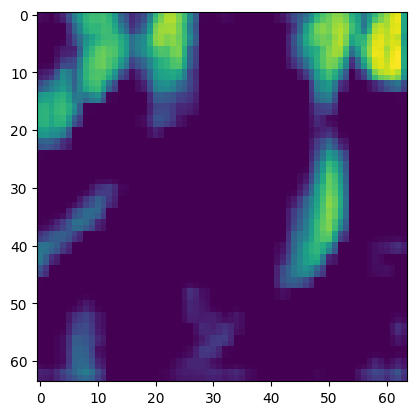

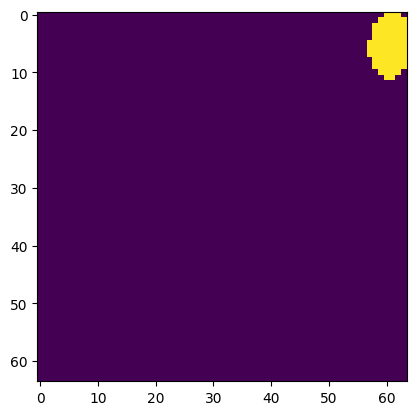

epoch 1/2, step 2710/3125, loss 34.738333511352536, acc 0.46359923481941223, time 1:23:05.280158
epoch 1/2, step 2720/3125, loss 33.37943572998047, acc 0.4587925672531128, time 1:23:21.686226
epoch 1/2, step 2730/3125, loss 33.18639659881592, acc 0.5331034064292908, time 1:23:38.591255
epoch 1/2, step 2740/3125, loss 33.38970127105713, acc 0.4837777614593506, time 1:23:55.143898
epoch 1/2, step 2750/3125, loss 36.30720195770264, acc 0.42244818806648254, time 1:24:12.015198
epoch 1/2, step 2760/3125, loss 35.32824897766113, acc 0.41343963146209717, time 1:24:28.695738
epoch 1/2, step 2770/3125, loss 32.19875259399414, acc 0.4914635121822357, time 1:24:46.008520
epoch 1/2, step 2780/3125, loss 35.328779792785646, acc 0.486329585313797, time 1:25:02.787430
epoch 1/2, step 2790/3125, loss 34.324799156188966, acc 0.5341193079948425, time 1:25:20.151438
epoch 1/2, step 2800/3125, loss 33.183980751037595, acc 0.5277911424636841, time 1:25:36.541567


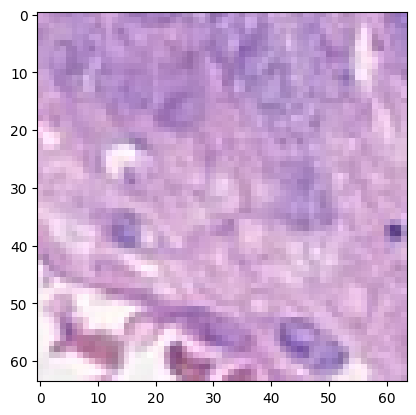

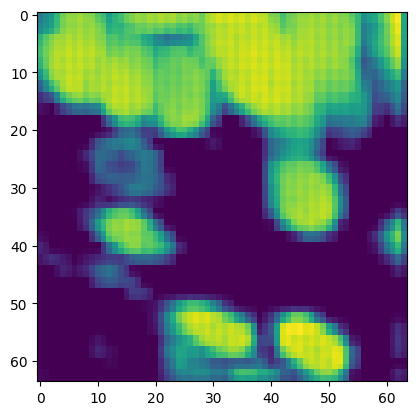

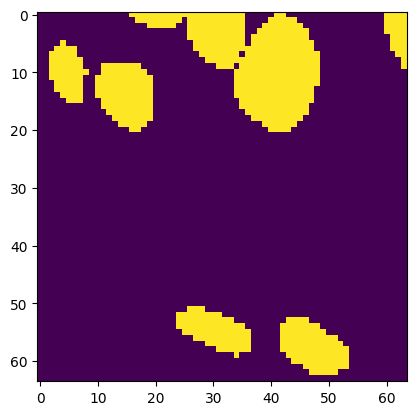

epoch 1/2, step 2810/3125, loss 34.035477256774904, acc 0.5042133331298828, time 1:25:54.161712
epoch 1/2, step 2820/3125, loss 34.23611850738526, acc 0.48413848876953125, time 1:26:11.367848
epoch 1/2, step 2830/3125, loss 34.45160312652588, acc 0.48235997557640076, time 1:26:28.370459
epoch 1/2, step 2840/3125, loss 34.00151443481445, acc 0.5280981659889221, time 1:26:44.990761
epoch 1/2, step 2850/3125, loss 36.58572196960449, acc 0.5050221085548401, time 1:27:01.389599
epoch 1/2, step 2860/3125, loss 34.26314849853516, acc 0.5278939008712769, time 1:27:18.460220
epoch 1/2, step 2870/3125, loss 34.172753524780276, acc 0.460803359746933, time 1:27:35.640730
epoch 1/2, step 2880/3125, loss 33.91594543457031, acc 0.481503427028656, time 1:27:52.099240
epoch 1/2, step 2890/3125, loss 33.863327217102054, acc 0.45321890711784363, time 1:28:08.835552
epoch 1/2, step 2900/3125, loss 35.406258010864256, acc 0.5002754926681519, time 1:28:25.553672


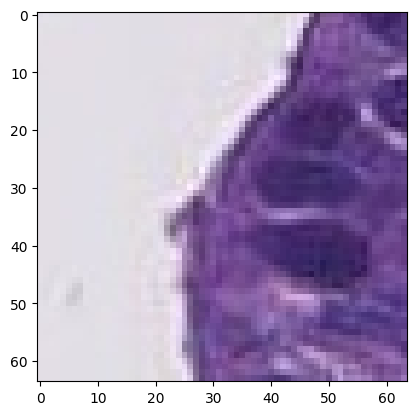

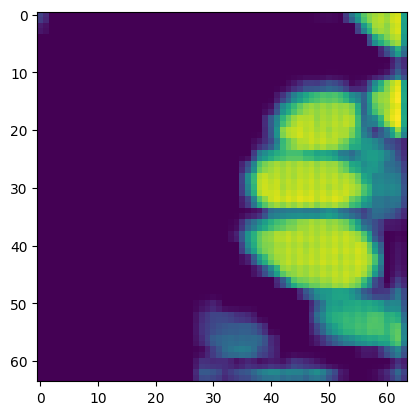

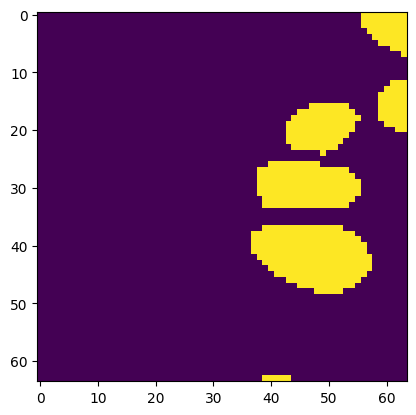

epoch 1/2, step 2910/3125, loss 34.83045845031738, acc 0.47667428851127625, time 1:28:42.409550
epoch 1/2, step 2920/3125, loss 34.1751895904541, acc 0.4658334255218506, time 1:28:58.983779
epoch 1/2, step 2930/3125, loss 31.84742374420166, acc 0.44622719287872314, time 1:29:15.802536
epoch 1/2, step 2940/3125, loss 33.906690406799314, acc 0.46951085329055786, time 1:29:32.539806
epoch 1/2, step 2950/3125, loss 31.49936447143555, acc 0.5066221356391907, time 1:29:48.745463
epoch 1/2, step 2960/3125, loss 33.18500690460205, acc 0.43394821882247925, time 1:30:05.377919
epoch 1/2, step 2970/3125, loss 34.35423183441162, acc 0.44328564405441284, time 1:30:22.146904
epoch 1/2, step 2980/3125, loss 34.36317901611328, acc 0.5147188901901245, time 1:30:39.211121
epoch 1/2, step 2990/3125, loss 35.42801628112793, acc 0.48825809359550476, time 1:30:55.736613
epoch 1/2, step 3000/3125, loss 36.53136444091797, acc 0.5107511281967163, time 1:31:12.613045


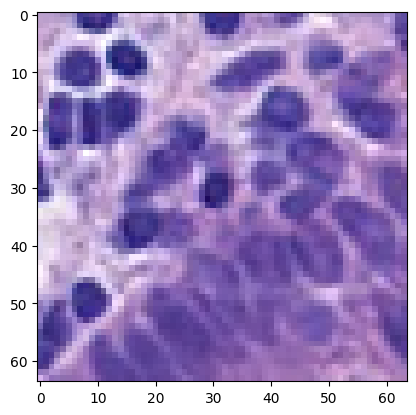

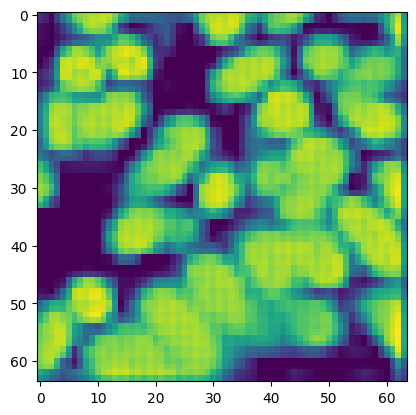

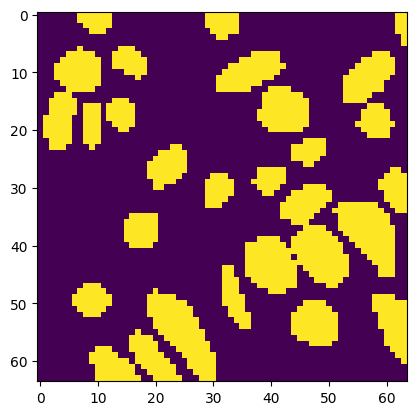

epoch 1/2, step 3010/3125, loss 34.24645938873291, acc 0.5042832493782043, time 1:31:29.752588
epoch 1/2, step 3020/3125, loss 34.40456676483154, acc 0.4166754484176636, time 1:31:46.292922
epoch 1/2, step 3030/3125, loss 33.379625511169436, acc 0.5068853497505188, time 1:32:02.839890
epoch 1/2, step 3040/3125, loss 31.954190063476563, acc 0.4923616945743561, time 1:32:19.217036
epoch 1/2, step 3050/3125, loss 33.620742607116696, acc 0.43614551424980164, time 1:32:36.971051
epoch 1/2, step 3060/3125, loss 33.52589359283447, acc 0.4616308808326721, time 1:32:55.552117
epoch 1/2, step 3070/3125, loss 33.45674076080322, acc 0.41950368881225586, time 1:33:12.781820
epoch 1/2, step 3080/3125, loss 33.448721694946286, acc 0.4734598398208618, time 1:33:29.595117
epoch 1/2, step 3090/3125, loss 33.00677890777588, acc 0.44495490193367004, time 1:33:46.496575
epoch 1/2, step 3100/3125, loss 34.5605972290039, acc 0.45853832364082336, time 1:34:03.213185


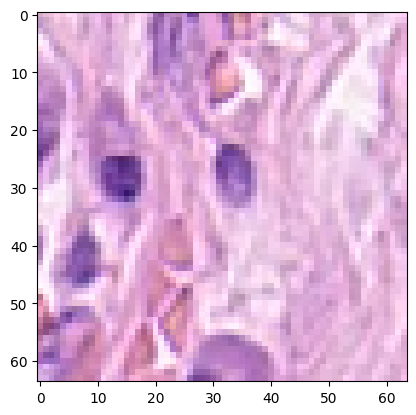

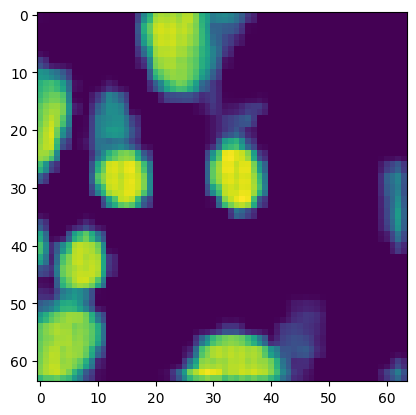

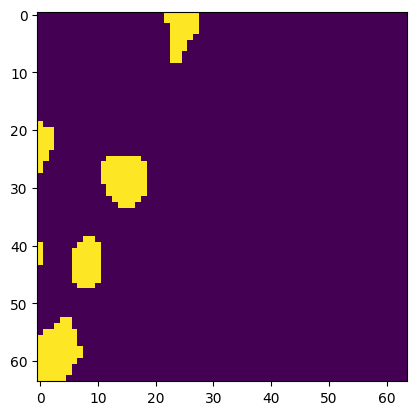

epoch 1/2, step 3110/3125, loss 35.09109516143799, acc 0.4567297697067261, time 1:34:20.382772
epoch 1/2, step 3120/3125, loss 34.63678817749023, acc 0.4876846671104431, time 1:34:36.886288
epoch 2/2, step 10/3125, loss 34.824350357055664, acc 0.4972178041934967, time 1:35:01.458298
epoch 2/2, step 20/3125, loss 35.14589672088623, acc 0.5079792737960815, time 1:35:17.896783
epoch 2/2, step 30/3125, loss 34.037868118286134, acc 0.4623335301876068, time 1:35:34.271542
epoch 2/2, step 40/3125, loss 34.66138687133789, acc 0.4591635465621948, time 1:35:51.357691
epoch 2/2, step 50/3125, loss 33.21946353912354, acc 0.47746741771698, time 1:36:08.264104
epoch 2/2, step 60/3125, loss 32.8533016204834, acc 0.4722852110862732, time 1:36:24.679869
epoch 2/2, step 70/3125, loss 33.399767303466795, acc 0.5058063268661499, time 1:36:41.163832
epoch 2/2, step 80/3125, loss 33.841088676452635, acc 0.39400768280029297, time 1:36:57.663833
epoch 2/2, step 90/3125, loss 34.34781055450439, acc 0.444819211

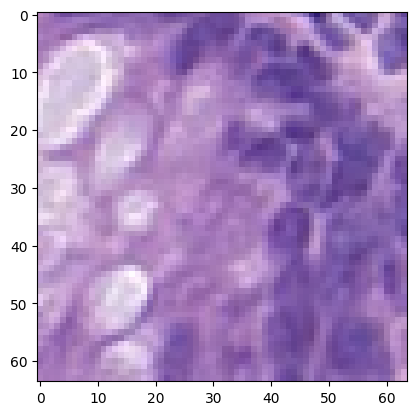

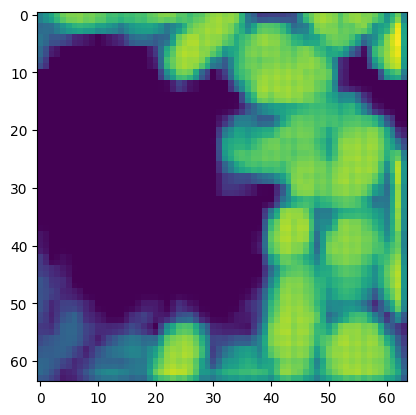

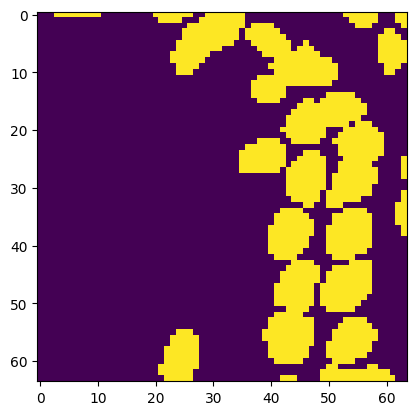

epoch 2/2, step 110/3125, loss 31.966993713378905, acc 0.434119313955307, time 1:37:47.673941
epoch 2/2, step 120/3125, loss 34.22617378234863, acc 0.4979822039604187, time 1:38:04.673941
epoch 2/2, step 130/3125, loss 33.76127815246582, acc 0.4521963596343994, time 1:38:21.221837
epoch 2/2, step 140/3125, loss 35.3695707321167, acc 0.48880866169929504, time 1:38:38.680628
epoch 2/2, step 150/3125, loss 35.045370483398436, acc 0.4896183907985687, time 1:38:55.042894
epoch 2/2, step 160/3125, loss 31.966331481933594, acc 0.4630929231643677, time 1:39:11.767328
epoch 2/2, step 170/3125, loss 32.16483974456787, acc 0.4443131685256958, time 1:39:28.065156
epoch 2/2, step 180/3125, loss 36.99479808807373, acc 0.5154995918273926, time 1:39:44.901055
epoch 2/2, step 190/3125, loss 34.25283908843994, acc 0.4963531494140625, time 1:40:01.734263
epoch 2/2, step 200/3125, loss 34.36014614105225, acc 0.5275474190711975, time 1:40:18.129003


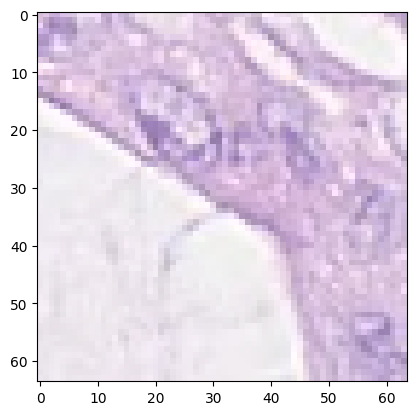

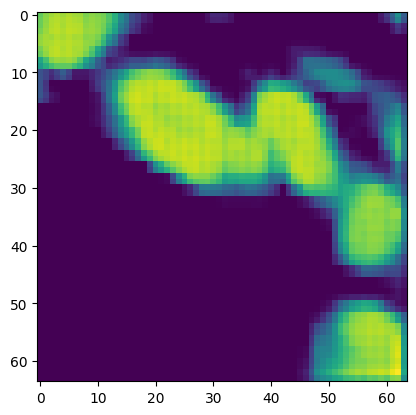

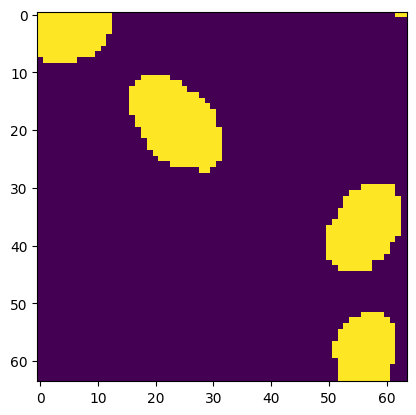

epoch 2/2, step 210/3125, loss 34.2765588760376, acc 0.45658567547798157, time 1:40:35.228606
epoch 2/2, step 220/3125, loss 31.471858787536622, acc 0.48556917905807495, time 1:40:52.908994
epoch 2/2, step 230/3125, loss 33.81090240478515, acc 0.5032734870910645, time 1:41:10.175777
epoch 2/2, step 240/3125, loss 33.02434616088867, acc 0.4866737425327301, time 1:41:26.413628
epoch 2/2, step 250/3125, loss 34.255231857299805, acc 0.48324012756347656, time 1:41:43.022970
epoch 2/2, step 260/3125, loss 35.081444931030276, acc 0.4980134963989258, time 1:42:00.008320
epoch 2/2, step 270/3125, loss 34.65689754486084, acc 0.5356408357620239, time 1:42:16.446358
epoch 2/2, step 280/3125, loss 34.23143463134765, acc 0.4218716621398926, time 1:42:33.130183
epoch 2/2, step 290/3125, loss 35.70778942108154, acc 0.46915632486343384, time 1:42:49.603890
epoch 2/2, step 300/3125, loss 35.955441856384276, acc 0.48904499411582947, time 1:43:05.996840


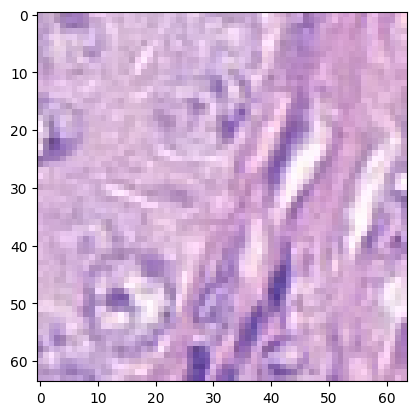

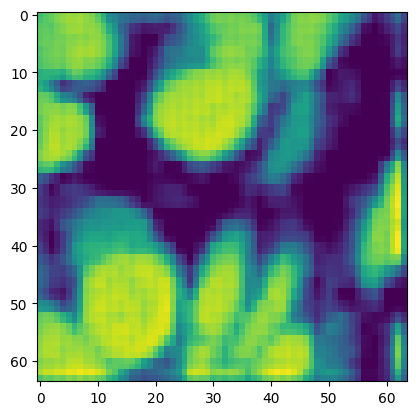

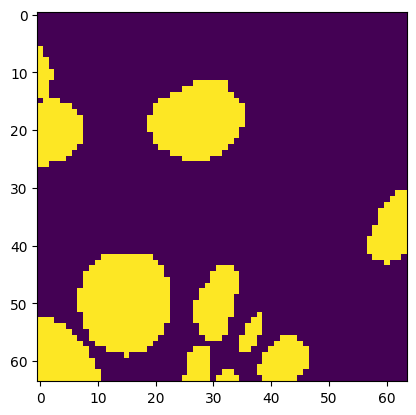

epoch 2/2, step 310/3125, loss 34.3632698059082, acc 0.4166748821735382, time 1:43:23.546058
epoch 2/2, step 320/3125, loss 35.113619804382324, acc 0.49336615204811096, time 1:43:39.948372
epoch 2/2, step 330/3125, loss 33.90091381072998, acc 0.5004913210868835, time 1:43:56.461763
epoch 2/2, step 340/3125, loss 34.33231048583984, acc 0.48525986075401306, time 1:44:13.155506
epoch 2/2, step 350/3125, loss 33.29580459594727, acc 0.42554065585136414, time 1:44:29.762438
epoch 2/2, step 360/3125, loss 35.750389099121094, acc 0.4557887315750122, time 1:44:46.652936
epoch 2/2, step 370/3125, loss 32.82952613830567, acc 0.4414926767349243, time 1:45:03.208503
epoch 2/2, step 380/3125, loss 34.05255832672119, acc 0.45395833253860474, time 1:45:20.060744
epoch 2/2, step 390/3125, loss 34.84556331634521, acc 0.4434962570667267, time 1:45:36.397632
epoch 2/2, step 400/3125, loss 34.85339698791504, acc 0.43798431754112244, time 1:45:52.615562


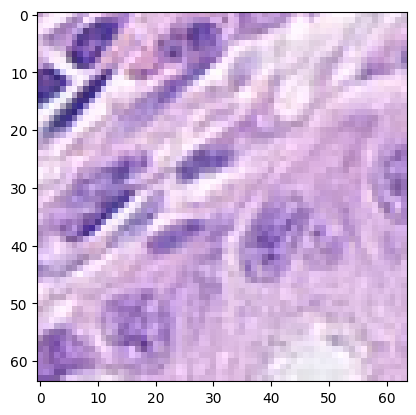

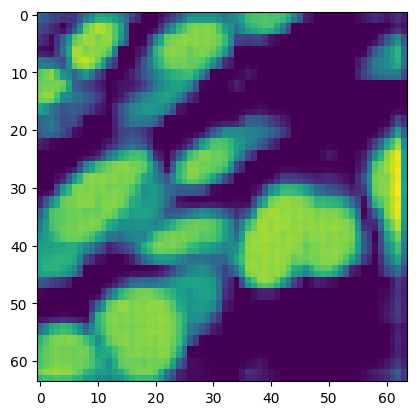

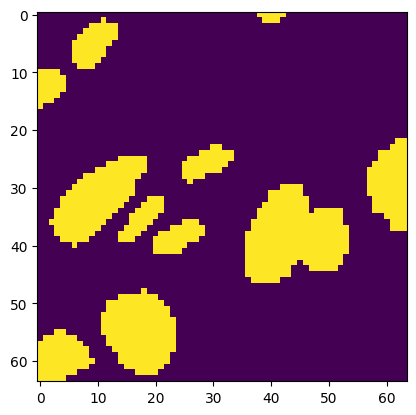

epoch 2/2, step 410/3125, loss 34.2233060836792, acc 0.48366013169288635, time 1:46:10.068130
epoch 2/2, step 420/3125, loss 35.09153232574463, acc 0.44200271368026733, time 1:46:26.613983
epoch 2/2, step 430/3125, loss 34.02914180755615, acc 0.4632583260536194, time 1:46:43.041256
epoch 2/2, step 440/3125, loss 34.2305046081543, acc 0.42520880699157715, time 1:47:00.359490
epoch 2/2, step 450/3125, loss 33.41592655181885, acc 0.4597827196121216, time 1:47:16.859496
epoch 2/2, step 460/3125, loss 32.435782241821286, acc 0.39513736963272095, time 1:47:33.309180
epoch 2/2, step 470/3125, loss 33.87451248168945, acc 0.4554121792316437, time 1:47:50.161894
epoch 2/2, step 480/3125, loss 34.47851505279541, acc 0.4391244947910309, time 1:48:06.631923
epoch 2/2, step 490/3125, loss 33.29179763793945, acc 0.45388683676719666, time 1:48:23.867825
epoch 2/2, step 500/3125, loss 32.858889198303224, acc 0.46093079447746277, time 1:48:40.267464


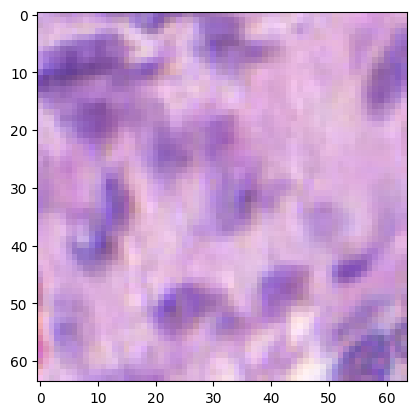

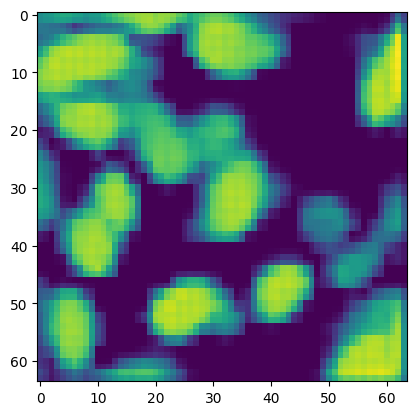

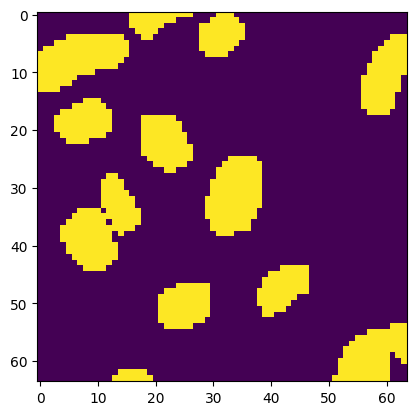

epoch 2/2, step 510/3125, loss 32.424476051330565, acc 0.455252468585968, time 1:49:05.369901
epoch 2/2, step 520/3125, loss 33.89382400512695, acc 0.4465871751308441, time 1:49:24.096116
epoch 2/2, step 530/3125, loss 36.36413497924805, acc 0.5215170979499817, time 1:49:42.822233
epoch 2/2, step 540/3125, loss 34.08516159057617, acc 0.4546906650066376, time 1:50:01.425399
epoch 2/2, step 550/3125, loss 32.97894401550293, acc 0.4913448691368103, time 1:50:19.129019
epoch 2/2, step 560/3125, loss 36.279137802124026, acc 0.44797611236572266, time 1:50:36.561282
epoch 2/2, step 570/3125, loss 33.66322479248047, acc 0.4493737816810608, time 1:50:54.500353
epoch 2/2, step 580/3125, loss 34.87243804931641, acc 0.45414865016937256, time 1:51:13.113854
epoch 2/2, step 590/3125, loss 34.40350685119629, acc 0.4762057960033417, time 1:51:30.361070
epoch 2/2, step 600/3125, loss 34.24601001739502, acc 0.4989074766635895, time 1:51:47.779378


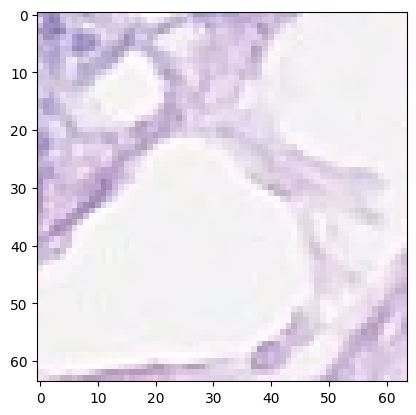

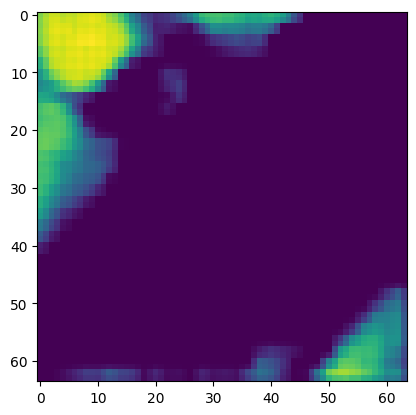

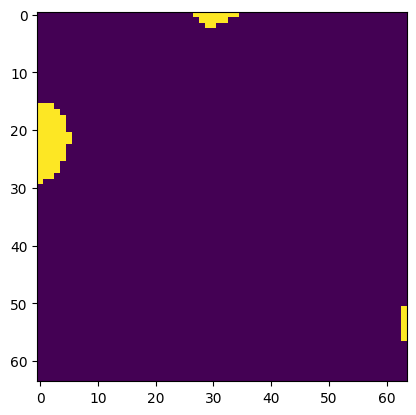

epoch 2/2, step 610/3125, loss 32.19798698425293, acc 0.43485695123672485, time 1:52:04.864033
epoch 2/2, step 620/3125, loss 33.01554355621338, acc 0.44832643866539, time 1:52:21.886022
epoch 2/2, step 630/3125, loss 33.262762451171874, acc 0.412618488073349, time 1:52:39.032001
epoch 2/2, step 640/3125, loss 34.86543426513672, acc 0.4100503623485565, time 1:52:56.312748
epoch 2/2, step 650/3125, loss 33.48362655639649, acc 0.5033842325210571, time 1:53:13.637122
epoch 2/2, step 660/3125, loss 34.488610458374026, acc 0.4679138958454132, time 1:53:30.716424
epoch 2/2, step 670/3125, loss 33.83021583557129, acc 0.46903929114341736, time 1:53:47.477378
epoch 2/2, step 680/3125, loss 34.22360038757324, acc 0.4960642158985138, time 1:54:04.684969
epoch 2/2, step 690/3125, loss 34.18016757965088, acc 0.4871898889541626, time 1:54:21.400647
epoch 2/2, step 700/3125, loss 34.62945919036865, acc 0.5039821863174438, time 1:54:38.817116


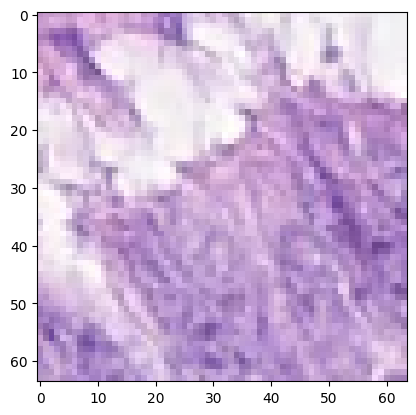

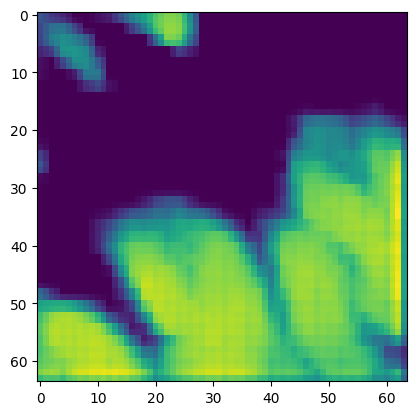

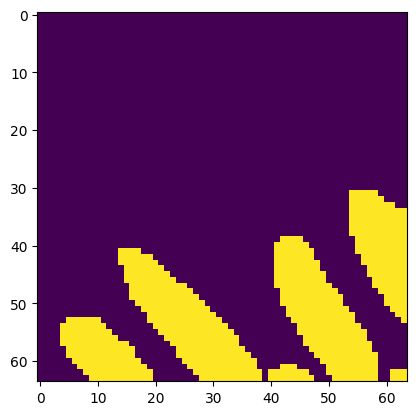

epoch 2/2, step 710/3125, loss 36.28645248413086, acc 0.5069026947021484, time 1:54:56.543803
epoch 2/2, step 720/3125, loss 35.14675731658936, acc 0.43460389971733093, time 1:55:13.407743
epoch 2/2, step 730/3125, loss 34.2130163192749, acc 0.4074360728263855, time 1:55:30.454058
epoch 2/2, step 740/3125, loss 34.56829566955567, acc 0.442207396030426, time 1:55:47.395700
epoch 2/2, step 750/3125, loss 35.15323543548584, acc 0.500750720500946, time 1:56:04.697166
epoch 2/2, step 760/3125, loss 34.047037315368655, acc 0.48031795024871826, time 1:56:21.698984
epoch 2/2, step 770/3125, loss 34.47908229827881, acc 0.4778822660446167, time 1:56:38.236702
epoch 2/2, step 780/3125, loss 32.19319438934326, acc 0.4465107023715973, time 1:56:55.107204
epoch 2/2, step 790/3125, loss 33.96973342895508, acc 0.4860302209854126, time 1:57:12.423962
epoch 2/2, step 800/3125, loss 33.41863880157471, acc 0.4127442240715027, time 1:57:28.749286


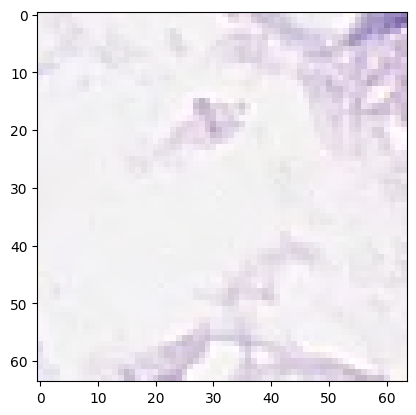

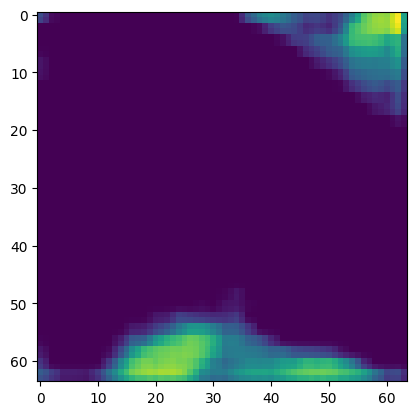

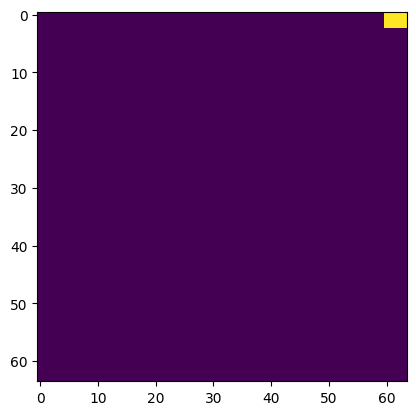

epoch 2/2, step 810/3125, loss 32.82720241546631, acc 0.44552886486053467, time 1:57:45.697873
epoch 2/2, step 820/3125, loss 33.40438270568848, acc 0.3995978832244873, time 1:58:02.532785
epoch 2/2, step 830/3125, loss 34.89733123779297, acc 0.47509974241256714, time 1:58:19.819564
epoch 2/2, step 840/3125, loss 32.821199607849124, acc 0.42901501059532166, time 1:58:35.869120
epoch 2/2, step 850/3125, loss 33.19005908966064, acc 0.47737666964530945, time 1:58:52.467169
epoch 2/2, step 860/3125, loss 35.65224914550781, acc 0.4632108807563782, time 1:59:09.139553
epoch 2/2, step 870/3125, loss 36.16638717651367, acc 0.47534123063087463, time 1:59:25.596789
epoch 2/2, step 880/3125, loss 35.63302001953125, acc 0.4910295903682709, time 1:59:42.542032
epoch 2/2, step 890/3125, loss 34.55867748260498, acc 0.4671461582183838, time 1:59:59.660156
epoch 2/2, step 900/3125, loss 34.88999767303467, acc 0.5007566809654236, time 2:00:15.828399


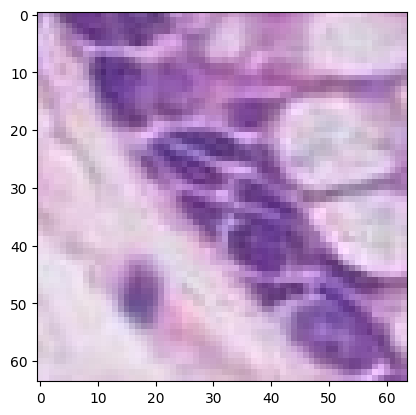

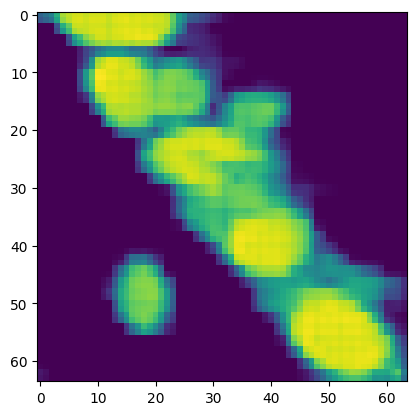

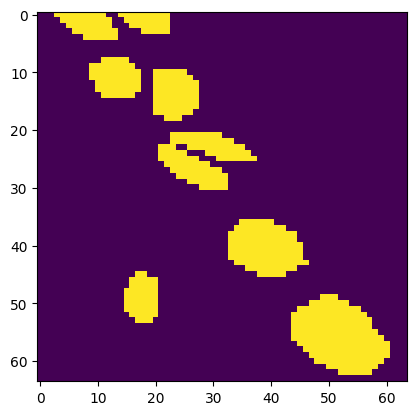

epoch 2/2, step 910/3125, loss 35.18736515045166, acc 0.42848077416419983, time 2:00:33.472186
epoch 2/2, step 920/3125, loss 32.10121173858643, acc 0.42894992232322693, time 2:00:50.826965
epoch 2/2, step 930/3125, loss 35.58425598144531, acc 0.5053179264068604, time 2:01:07.568285
epoch 2/2, step 940/3125, loss 32.59680366516113, acc 0.4375387132167816, time 2:01:28.595176
epoch 2/2, step 950/3125, loss 32.56161804199219, acc 0.4532914459705353, time 2:01:46.042783
epoch 2/2, step 960/3125, loss 33.420077896118165, acc 0.44322991371154785, time 2:02:02.667641
epoch 2/2, step 970/3125, loss 31.91669292449951, acc 0.4630178213119507, time 2:02:19.420491
epoch 2/2, step 980/3125, loss 35.12003440856934, acc 0.4180035889148712, time 2:02:36.610322
epoch 2/2, step 990/3125, loss 33.65818290710449, acc 0.43747085332870483, time 2:02:53.725855
epoch 2/2, step 1000/3125, loss 34.09877586364746, acc 0.44495537877082825, time 2:03:10.359274


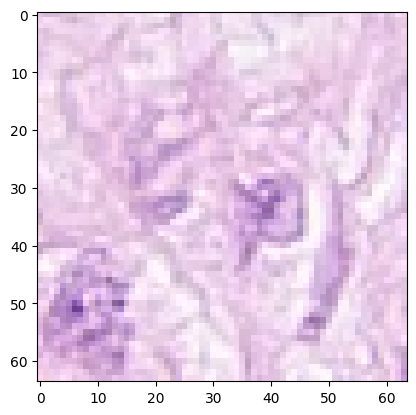

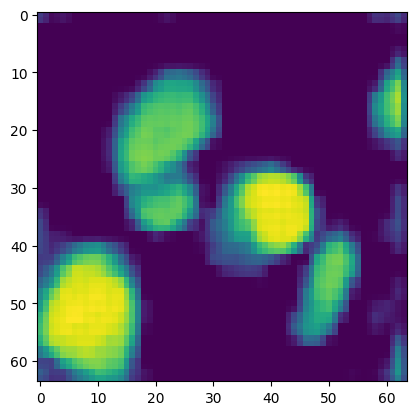

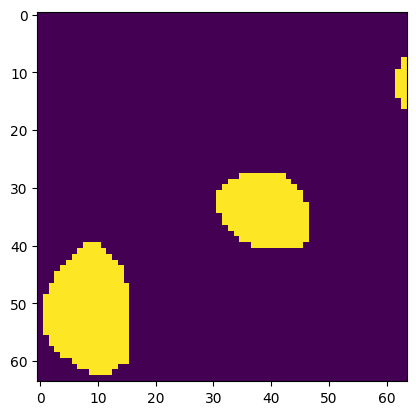

epoch 2/2, step 1010/3125, loss 33.8843599319458, acc 0.4564012587070465, time 2:03:27.499254
epoch 2/2, step 1020/3125, loss 34.844222450256346, acc 0.43399104475975037, time 2:03:45.089065
epoch 2/2, step 1030/3125, loss 33.670840644836424, acc 0.46993759274482727, time 2:04:03.268748
epoch 2/2, step 1040/3125, loss 33.452040672302246, acc 0.43740928173065186, time 2:04:20.335606
epoch 2/2, step 1050/3125, loss 35.92224617004395, acc 0.439335435628891, time 2:04:37.329360
epoch 2/2, step 1060/3125, loss 34.36010665893555, acc 0.4523656666278839, time 2:04:54.119146
epoch 2/2, step 1070/3125, loss 34.26492328643799, acc 0.38576042652130127, time 2:05:11.165863
epoch 2/2, step 1080/3125, loss 32.587836837768556, acc 0.47592219710350037, time 2:05:28.304753
epoch 2/2, step 1090/3125, loss 34.12602424621582, acc 0.4104437232017517, time 2:05:44.748277
epoch 2/2, step 1100/3125, loss 33.34026050567627, acc 0.44894763827323914, time 2:06:01.796639


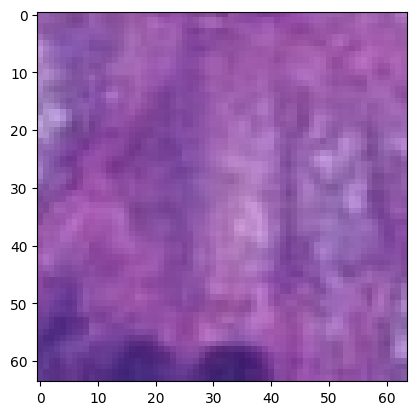

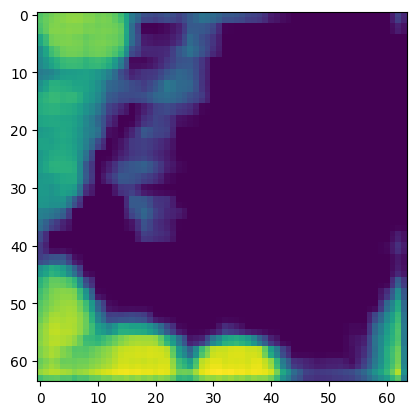

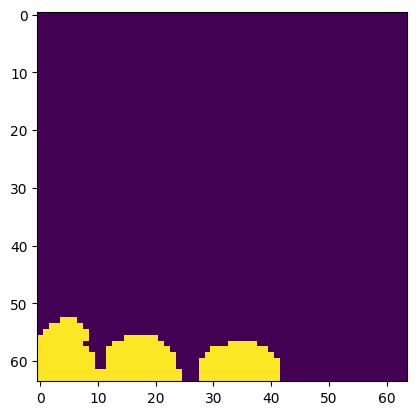

epoch 2/2, step 1110/3125, loss 35.40139789581299, acc 0.43066859245300293, time 2:06:19.387698
epoch 2/2, step 1120/3125, loss 33.84612045288086, acc 0.484518438577652, time 2:06:35.997691
epoch 2/2, step 1130/3125, loss 32.26134757995605, acc 0.4423345923423767, time 2:06:52.887502
epoch 2/2, step 1140/3125, loss 33.207143211364745, acc 0.4421369135379791, time 2:07:10.081078
epoch 2/2, step 1150/3125, loss 32.276160430908206, acc 0.4113430976867676, time 2:07:26.587716
epoch 2/2, step 1160/3125, loss 34.1691177368164, acc 0.4346984028816223, time 2:07:43.015709
epoch 2/2, step 1170/3125, loss 33.44679641723633, acc 0.46768948435783386, time 2:08:00.170006
epoch 2/2, step 1180/3125, loss 33.56525421142578, acc 0.41430947184562683, time 2:08:16.247445
epoch 2/2, step 1190/3125, loss 33.227464866638186, acc 0.4087599515914917, time 2:08:33.321994
epoch 2/2, step 1200/3125, loss 37.23212013244629, acc 0.44689467549324036, time 2:08:50.555205


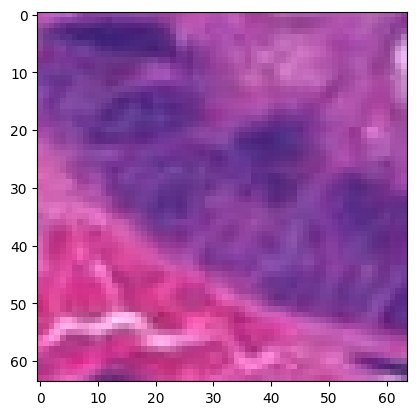

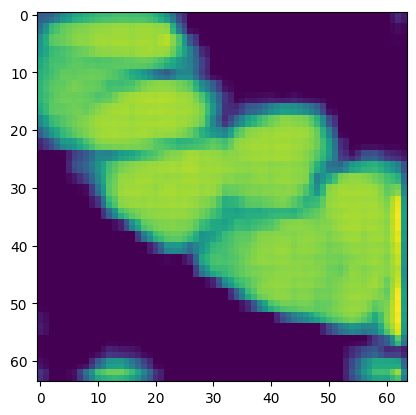

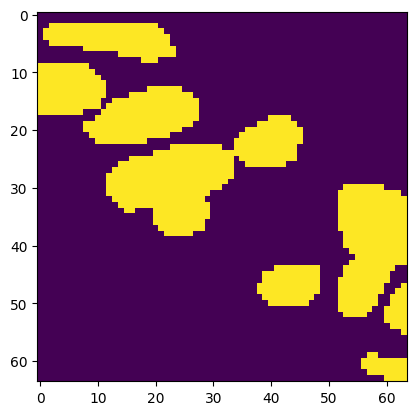

epoch 2/2, step 1210/3125, loss 35.18827514648437, acc 0.37297961115837097, time 2:09:08.365925
epoch 2/2, step 1220/3125, loss 32.166914749145505, acc 0.43175312876701355, time 2:09:26.548023
epoch 2/2, step 1230/3125, loss 34.48960456848145, acc 0.48229432106018066, time 2:09:42.832674
epoch 2/2, step 1240/3125, loss 35.16139812469483, acc 0.41337665915489197, time 2:09:59.561853
epoch 2/2, step 1250/3125, loss 33.279763793945314, acc 0.4019808769226074, time 2:10:15.958074
epoch 2/2, step 1260/3125, loss 33.93717231750488, acc 0.4005635380744934, time 2:10:33.357304
epoch 2/2, step 1270/3125, loss 33.55072860717773, acc 0.452473908662796, time 2:10:50.639872
epoch 2/2, step 1280/3125, loss 34.031491661071776, acc 0.45251089334487915, time 2:11:08.065001
epoch 2/2, step 1290/3125, loss 34.78485374450683, acc 0.5063158869743347, time 2:11:24.627391
epoch 2/2, step 1300/3125, loss 34.47360725402832, acc 0.4275546073913574, time 2:11:42.013076


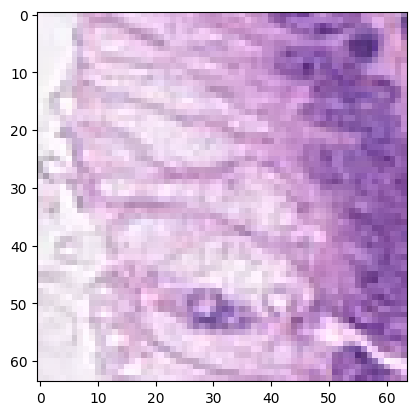

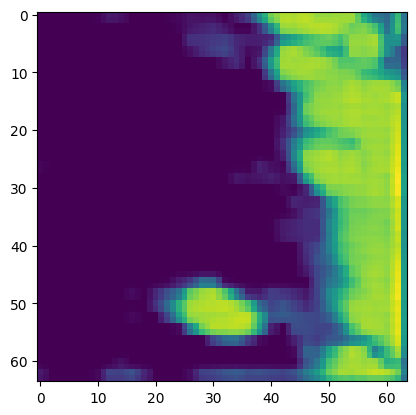

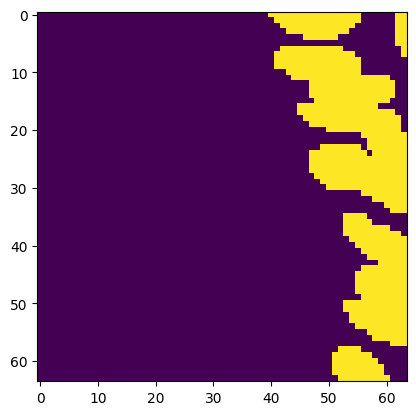

epoch 2/2, step 1310/3125, loss 34.18242626190185, acc 0.410641610622406, time 2:11:59.419051
epoch 2/2, step 1320/3125, loss 35.17761001586914, acc 0.46571603417396545, time 2:12:15.993300
epoch 2/2, step 1330/3125, loss 33.69404830932617, acc 0.4244999885559082, time 2:12:32.919603
epoch 2/2, step 1340/3125, loss 32.59958038330078, acc 0.3970966637134552, time 2:12:49.812169
epoch 2/2, step 1350/3125, loss 34.73545913696289, acc 0.43932193517684937, time 2:13:06.456166
epoch 2/2, step 1360/3125, loss 34.869599151611325, acc 0.4677642285823822, time 2:13:23.333166
epoch 2/2, step 1370/3125, loss 35.415398025512694, acc 0.44580280780792236, time 2:13:40.075845
epoch 2/2, step 1380/3125, loss 33.45057563781738, acc 0.4613374173641205, time 2:13:56.540810
epoch 2/2, step 1390/3125, loss 33.794052314758304, acc 0.45595434308052063, time 2:14:13.864196
epoch 2/2, step 1400/3125, loss 32.67821445465088, acc 0.4150427281856537, time 2:14:30.231704


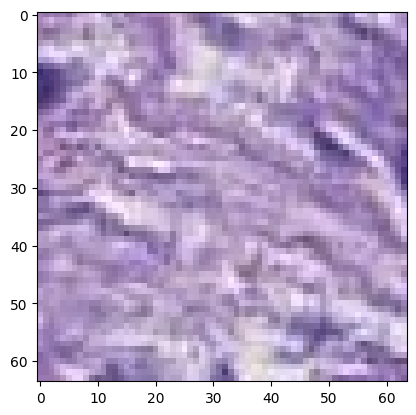

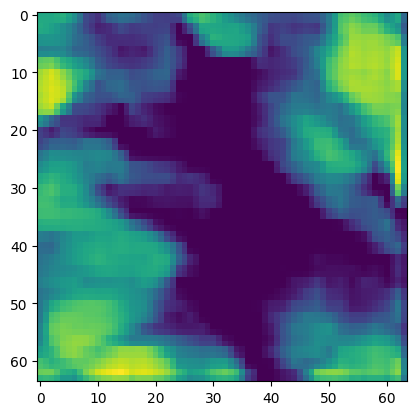

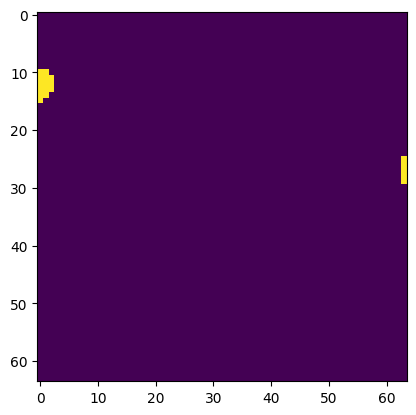

epoch 2/2, step 1410/3125, loss 35.18983840942383, acc 0.43875715136528015, time 2:14:47.089698
epoch 2/2, step 1420/3125, loss 35.3892879486084, acc 0.4778141677379608, time 2:15:04.390979
epoch 2/2, step 1430/3125, loss 33.56759243011474, acc 0.42503294348716736, time 2:15:21.602735
epoch 2/2, step 1440/3125, loss 35.40064010620117, acc 0.39545390009880066, time 2:15:38.347056
epoch 2/2, step 1450/3125, loss 34.28955764770508, acc 0.48793479800224304, time 2:15:55.009106
epoch 2/2, step 1460/3125, loss 34.05658397674561, acc 0.4137692153453827, time 2:16:11.861675
epoch 2/2, step 1470/3125, loss 34.016381072998044, acc 0.5103817582130432, time 2:16:28.317687
epoch 2/2, step 1480/3125, loss 33.939254188537596, acc 0.48671954870224, time 2:16:45.097927
epoch 2/2, step 1490/3125, loss 33.21411819458008, acc 0.5065620541572571, time 2:17:02.448697
epoch 2/2, step 1500/3125, loss 34.27669410705566, acc 0.4300746023654938, time 2:17:18.018698


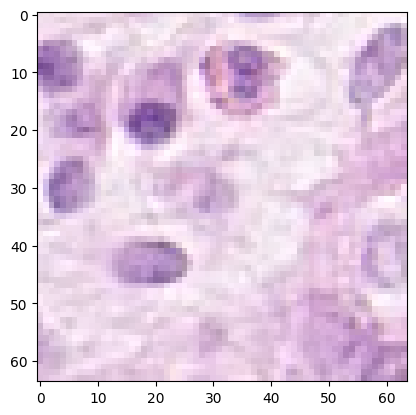

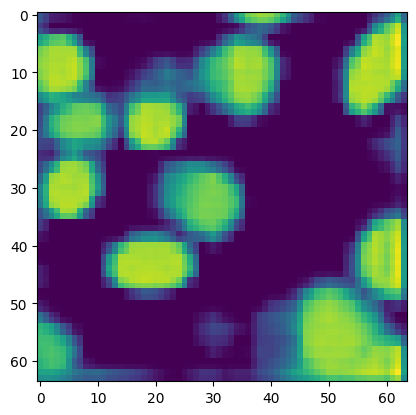

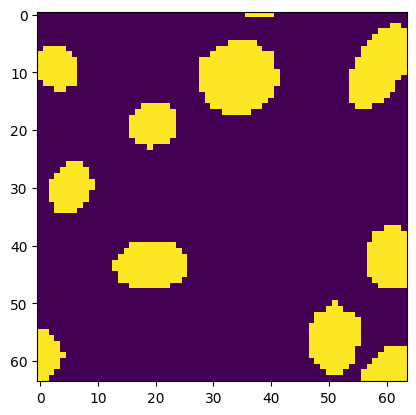

epoch 2/2, step 1510/3125, loss 33.57572269439697, acc 0.48370999097824097, time 2:17:34.546438
epoch 2/2, step 1520/3125, loss 33.99666423797608, acc 0.4505849778652191, time 2:17:51.459907
epoch 2/2, step 1530/3125, loss 33.59387626647949, acc 0.46610894799232483, time 2:18:08.601157
epoch 2/2, step 1540/3125, loss 35.32384262084961, acc 0.4755495488643646, time 2:18:24.662077
epoch 2/2, step 1550/3125, loss 35.44369812011719, acc 0.4315226674079895, time 2:18:41.536734
epoch 2/2, step 1560/3125, loss 36.850961685180664, acc 0.4894143342971802, time 2:18:58.686431
epoch 2/2, step 1570/3125, loss 34.28309593200684, acc 0.3991774320602417, time 2:19:15.293936
epoch 2/2, step 1580/3125, loss 35.421142768859866, acc 0.4655461609363556, time 2:19:32.592847
epoch 2/2, step 1590/3125, loss 34.51235427856445, acc 0.4740616977214813, time 2:19:49.496405
epoch 2/2, step 1600/3125, loss 36.45821952819824, acc 0.45233237743377686, time 2:20:06.213820


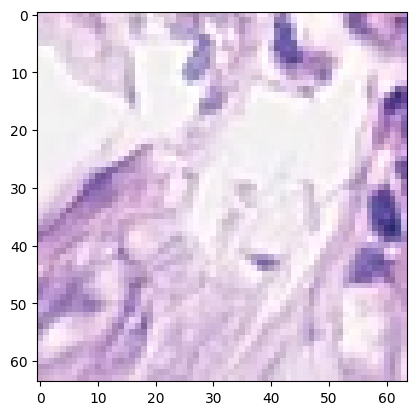

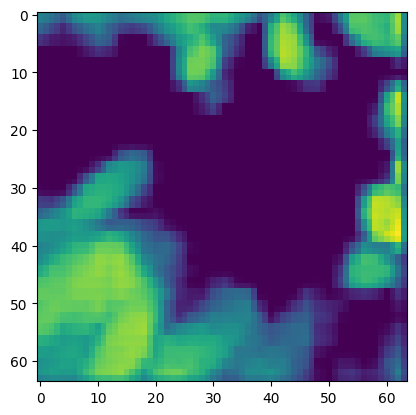

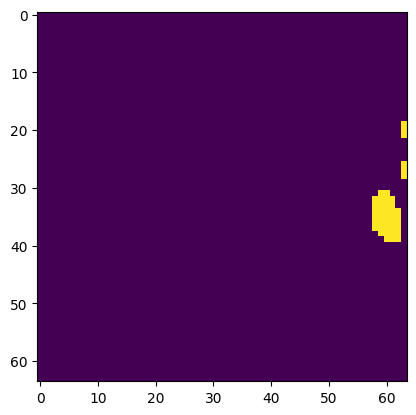

epoch 2/2, step 1610/3125, loss 32.25738716125488, acc 0.47539305686950684, time 2:20:23.070478
epoch 2/2, step 1620/3125, loss 33.04042434692383, acc 0.47951948642730713, time 2:20:40.213471
epoch 2/2, step 1630/3125, loss 34.794260787963864, acc 0.4406239092350006, time 2:20:57.698748
epoch 2/2, step 1640/3125, loss 34.55151100158692, acc 0.47484394907951355, time 2:21:14.293530
epoch 2/2, step 1650/3125, loss 36.00612163543701, acc 0.518318772315979, time 2:21:31.365008
epoch 2/2, step 1660/3125, loss 33.72544631958008, acc 0.4523375332355499, time 2:21:47.873511
epoch 2/2, step 1670/3125, loss 35.44340496063232, acc 0.44647520780563354, time 2:22:04.192999
epoch 2/2, step 1680/3125, loss 33.74099502563477, acc 0.446007639169693, time 2:22:20.499800
epoch 2/2, step 1690/3125, loss 34.94265270233154, acc 0.46591323614120483, time 2:22:37.598657
epoch 2/2, step 1700/3125, loss 32.23889083862305, acc 0.4378538727760315, time 2:22:54.523226


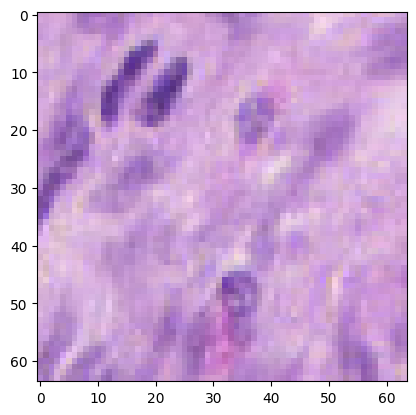

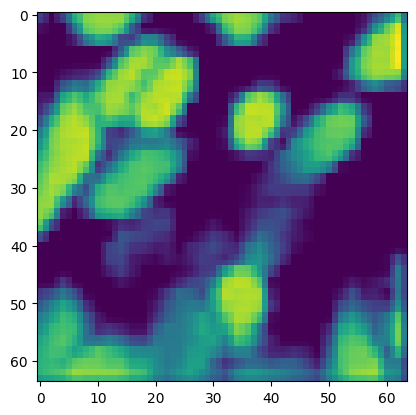

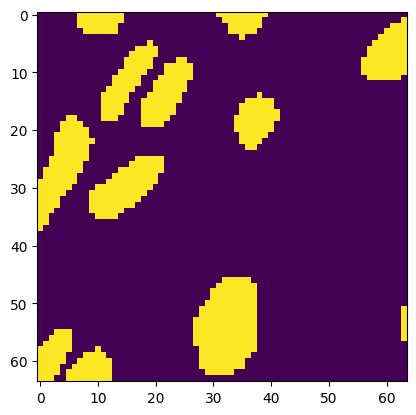

epoch 2/2, step 1710/3125, loss 32.31484680175781, acc 0.4709387421607971, time 2:23:11.222811
epoch 2/2, step 1720/3125, loss 33.60560245513916, acc 0.4440620541572571, time 2:23:28.325299
epoch 2/2, step 1730/3125, loss 32.916419982910156, acc 0.4685061573982239, time 2:23:45.140721
epoch 2/2, step 1740/3125, loss 35.11056404113769, acc 0.44706031680107117, time 2:24:01.414246
epoch 2/2, step 1750/3125, loss 35.00016841888428, acc 0.44238629937171936, time 2:24:17.989401
epoch 2/2, step 1760/3125, loss 32.91284656524658, acc 0.416962206363678, time 2:24:35.340561
epoch 2/2, step 1770/3125, loss 33.610622024536134, acc 0.4014800488948822, time 2:24:51.819200
epoch 2/2, step 1780/3125, loss 33.52948360443115, acc 0.39818626642227173, time 2:25:08.820626
epoch 2/2, step 1790/3125, loss 33.279812049865725, acc 0.4704638421535492, time 2:25:25.537202
epoch 2/2, step 1800/3125, loss 32.09295215606689, acc 0.420198917388916, time 2:25:41.868482


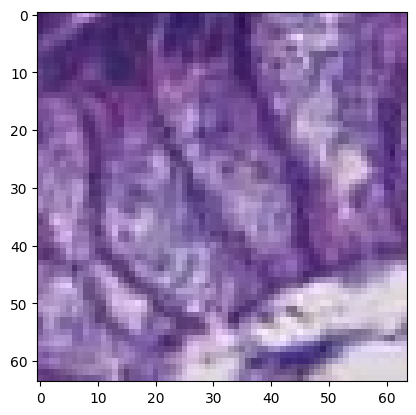

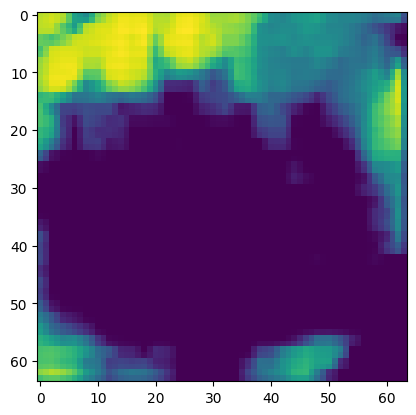

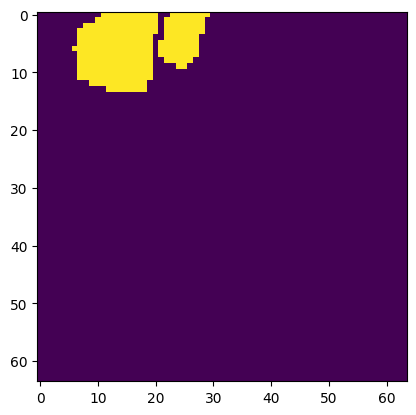

epoch 2/2, step 1810/3125, loss 36.2113956451416, acc 0.4979594349861145, time 2:25:59.755658
epoch 2/2, step 1820/3125, loss 34.89527435302735, acc 0.4906979203224182, time 2:26:16.739046
epoch 2/2, step 1830/3125, loss 33.315832901000974, acc 0.4017943739891052, time 2:26:33.113489
epoch 2/2, step 1840/3125, loss 34.67490825653076, acc 0.424431174993515, time 2:26:49.696713
epoch 2/2, step 1850/3125, loss 34.064391899108884, acc 0.4215024411678314, time 2:27:06.296478
epoch 2/2, step 1860/3125, loss 35.38481750488281, acc 0.49802839756011963, time 2:27:23.169826
epoch 2/2, step 1870/3125, loss 34.49090843200683, acc 0.44612014293670654, time 2:27:39.947912
epoch 2/2, step 1880/3125, loss 33.577012062072754, acc 0.47534996271133423, time 2:27:56.619048
epoch 2/2, step 1890/3125, loss 34.466795921325684, acc 0.4594511091709137, time 2:28:13.003486
epoch 2/2, step 1900/3125, loss 33.69656391143799, acc 0.4338380694389343, time 2:28:29.589060


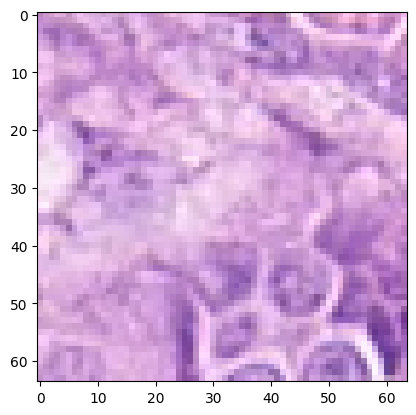

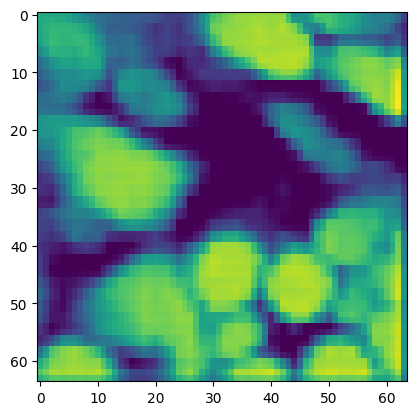

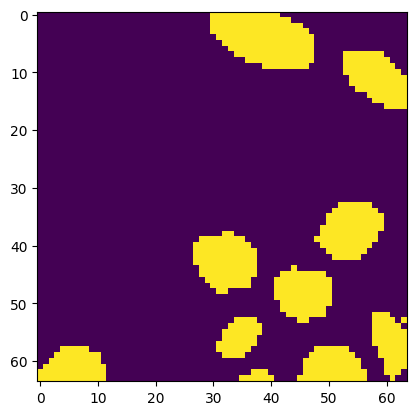

epoch 2/2, step 1910/3125, loss 34.274495887756345, acc 0.5212942957878113, time 2:28:46.998532
epoch 2/2, step 1920/3125, loss 34.01144027709961, acc 0.439968079328537, time 2:29:03.348328
epoch 2/2, step 1930/3125, loss 33.34614372253418, acc 0.4600740373134613, time 2:29:19.745226
epoch 2/2, step 1940/3125, loss 36.73913726806641, acc 0.41476473212242126, time 2:29:36.745509
epoch 2/2, step 1950/3125, loss 35.00050506591797, acc 0.4539616107940674, time 2:29:53.113653
epoch 2/2, step 1960/3125, loss 33.33283958435059, acc 0.44203922152519226, time 2:30:09.680746
epoch 2/2, step 1970/3125, loss 37.199134063720706, acc 0.4668983817100525, time 2:30:26.565823
epoch 2/2, step 1980/3125, loss 32.40240879058838, acc 0.3912675976753235, time 2:30:43.733723
epoch 2/2, step 1990/3125, loss 33.66939430236816, acc 0.41077759861946106, time 2:31:00.225420
epoch 2/2, step 2000/3125, loss 34.49306087493896, acc 0.4436090588569641, time 2:31:17.366874


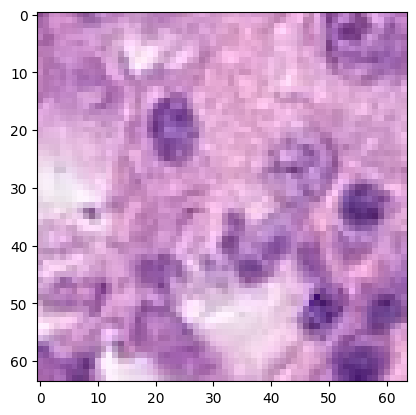

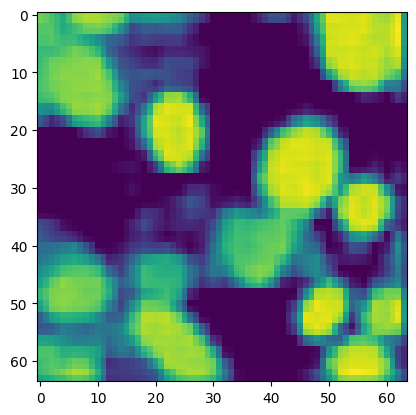

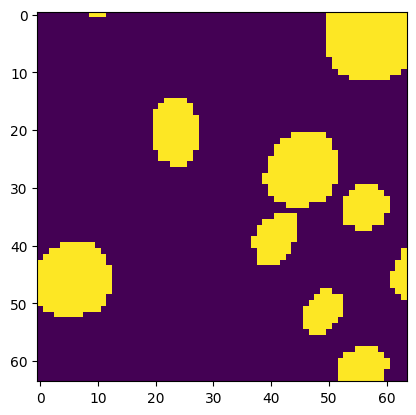

epoch 2/2, step 2010/3125, loss 35.853003311157224, acc 0.475742906332016, time 2:31:34.865569
epoch 2/2, step 2020/3125, loss 37.08670654296875, acc 0.485571950674057, time 2:31:51.393983
epoch 2/2, step 2030/3125, loss 32.09749565124512, acc 0.4014977216720581, time 2:32:07.640377
epoch 2/2, step 2040/3125, loss 35.44380435943604, acc 0.41202884912490845, time 2:32:24.218686
epoch 2/2, step 2050/3125, loss 34.23834457397461, acc 0.42009416222572327, time 2:32:43.269810
epoch 2/2, step 2060/3125, loss 34.265144157409665, acc 0.41105175018310547, time 2:33:01.928348
epoch 2/2, step 2070/3125, loss 35.366987991333005, acc 0.4707767069339752, time 2:33:18.943788
epoch 2/2, step 2080/3125, loss 33.118917274475095, acc 0.46397915482521057, time 2:33:36.502531
epoch 2/2, step 2090/3125, loss 32.45382118225098, acc 0.5135639905929565, time 2:33:54.029893
epoch 2/2, step 2100/3125, loss 34.46425189971924, acc 0.44910508394241333, time 2:34:10.300554


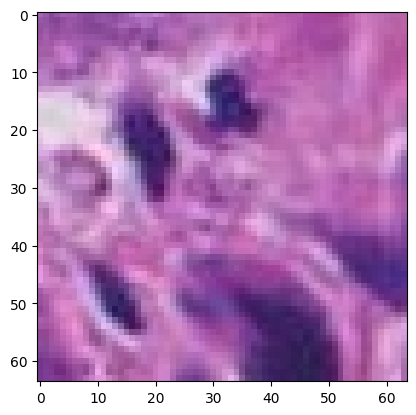

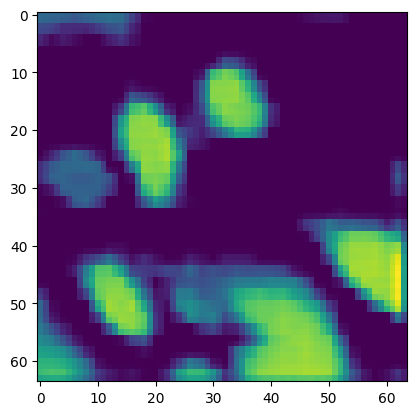

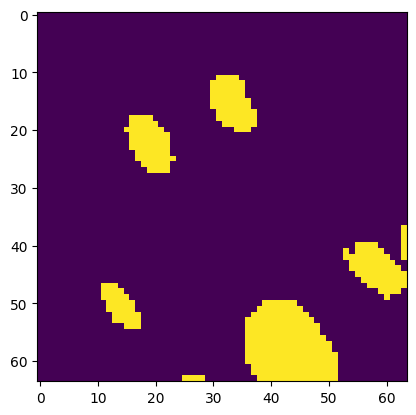

epoch 2/2, step 2110/3125, loss 35.49192180633545, acc 0.4101467430591583, time 2:34:27.228887
epoch 2/2, step 2120/3125, loss 34.20095920562744, acc 0.42295873165130615, time 2:34:44.446133
epoch 2/2, step 2130/3125, loss 34.518498229980466, acc 0.4076102674007416, time 2:35:00.823068
epoch 2/2, step 2140/3125, loss 31.861814117431642, acc 0.4379807710647583, time 2:35:17.248100
epoch 2/2, step 2150/3125, loss 33.80134944915771, acc 0.44040533900260925, time 2:35:33.662432
epoch 2/2, step 2160/3125, loss 34.08030681610107, acc 0.4208551347255707, time 2:35:50.453620
epoch 2/2, step 2170/3125, loss 34.53856353759765, acc 0.46379804611206055, time 2:36:06.779765
epoch 2/2, step 2180/3125, loss 34.91463279724121, acc 0.4062860906124115, time 2:36:23.895187
epoch 2/2, step 2190/3125, loss 35.14392166137695, acc 0.39464160799980164, time 2:36:40.630986
epoch 2/2, step 2200/3125, loss 33.09442653656006, acc 0.4897371232509613, time 2:36:57.152531


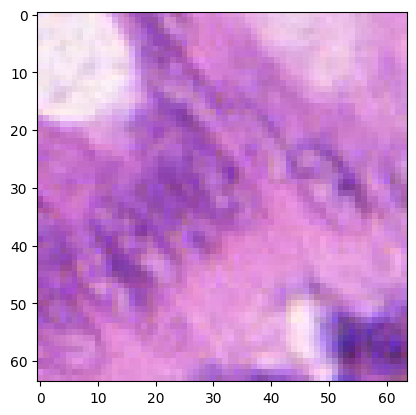

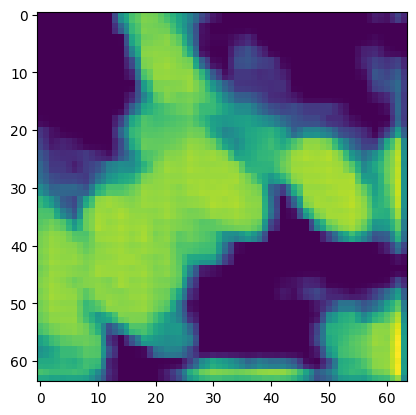

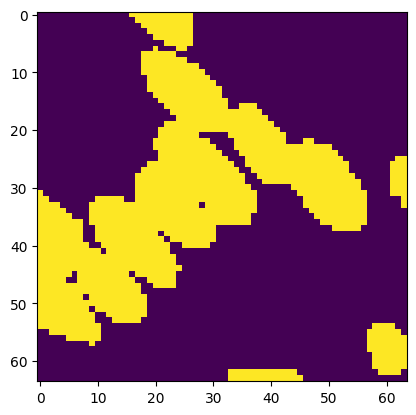

epoch 2/2, step 2210/3125, loss 32.048217964172366, acc 0.4371661841869354, time 2:37:14.210241
epoch 2/2, step 2220/3125, loss 33.56168842315674, acc 0.4430450201034546, time 2:37:30.961945
epoch 2/2, step 2230/3125, loss 33.06587181091309, acc 0.5145020484924316, time 2:37:47.904453
epoch 2/2, step 2240/3125, loss 34.0239818572998, acc 0.441164493560791, time 2:38:04.281299
epoch 2/2, step 2250/3125, loss 34.05478096008301, acc 0.4320950210094452, time 2:38:21.504522
epoch 2/2, step 2260/3125, loss 34.14142532348633, acc 0.46946418285369873, time 2:38:37.938159
epoch 2/2, step 2270/3125, loss 34.321459197998045, acc 0.4134249985218048, time 2:38:54.254971
epoch 2/2, step 2280/3125, loss 32.4320426940918, acc 0.42607301473617554, time 2:39:11.094057
epoch 2/2, step 2290/3125, loss 33.462401390075684, acc 0.4320136308670044, time 2:39:27.399078
epoch 2/2, step 2300/3125, loss 33.67896423339844, acc 0.46398934721946716, time 2:39:43.983205


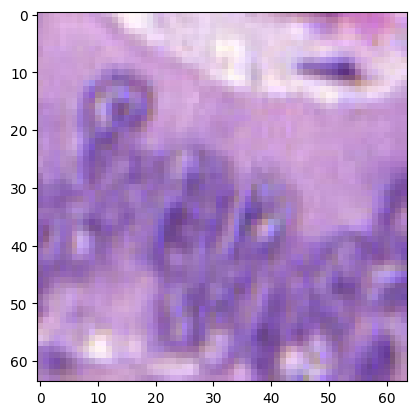

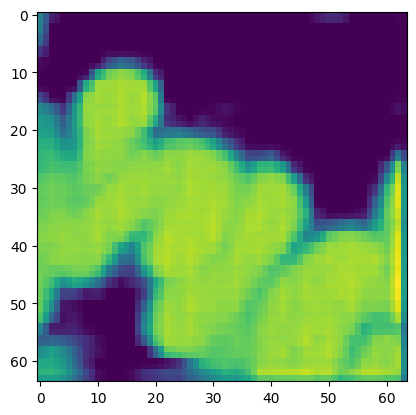

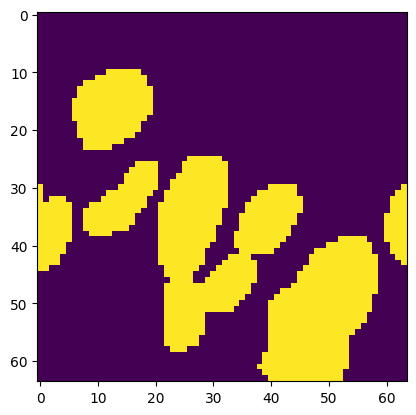

epoch 2/2, step 2310/3125, loss 33.58106670379639, acc 0.4537668526172638, time 2:40:01.212075
epoch 2/2, step 2320/3125, loss 34.44687900543213, acc 0.44303297996520996, time 2:40:18.083412
epoch 2/2, step 2330/3125, loss 32.77901611328125, acc 0.41308069229125977, time 2:40:34.357442
epoch 2/2, step 2340/3125, loss 35.013372611999515, acc 0.42980334162712097, time 2:40:51.801131
epoch 2/2, step 2350/3125, loss 32.917576217651366, acc 0.43910565972328186, time 2:41:08.643612
epoch 2/2, step 2360/3125, loss 31.928126335144043, acc 0.4208032488822937, time 2:41:25.446118
epoch 2/2, step 2370/3125, loss 34.36636180877686, acc 0.46036630868911743, time 2:41:41.589587
epoch 2/2, step 2380/3125, loss 34.21608600616455, acc 0.44933730363845825, time 2:41:58.378704
epoch 2/2, step 2390/3125, loss 33.01354808807373, acc 0.43417274951934814, time 2:42:14.803296
epoch 2/2, step 2400/3125, loss 34.90390853881836, acc 0.4694291353225708, time 2:42:32.050145


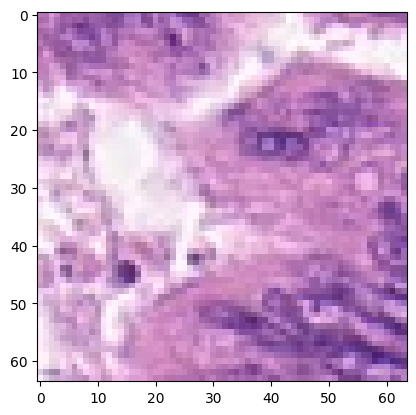

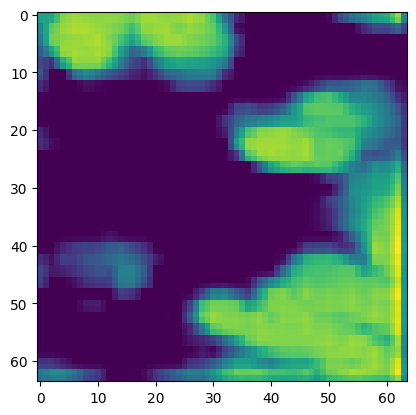

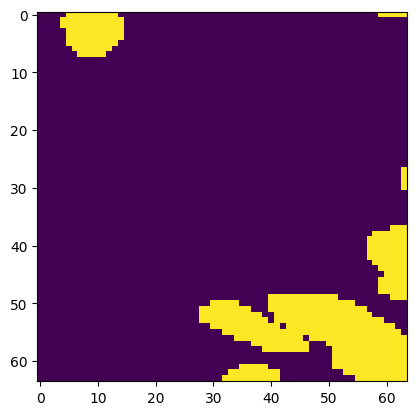

epoch 2/2, step 2410/3125, loss 33.26589660644531, acc 0.4236932694911957, time 2:42:53.915064
epoch 2/2, step 2420/3125, loss 34.590126037597656, acc 0.4170333445072174, time 2:43:12.118438
epoch 2/2, step 2430/3125, loss 33.61002902984619, acc 0.41372057795524597, time 2:43:32.631426
epoch 2/2, step 2440/3125, loss 35.46701011657715, acc 0.37895843386650085, time 2:43:52.090968
epoch 2/2, step 2450/3125, loss 34.59128036499023, acc 0.43613049387931824, time 2:44:13.011570
epoch 2/2, step 2460/3125, loss 34.40422191619873, acc 0.4339453876018524, time 2:44:35.189586
epoch 2/2, step 2470/3125, loss 34.818112182617185, acc 0.42081212997436523, time 2:44:53.453662
epoch 2/2, step 2480/3125, loss 34.28025035858154, acc 0.49668267369270325, time 2:45:10.731254
epoch 2/2, step 2490/3125, loss 34.1763916015625, acc 0.44143933057785034, time 2:45:28.179471
epoch 2/2, step 2500/3125, loss 32.58732891082764, acc 0.4769464433193207, time 2:45:45.688522


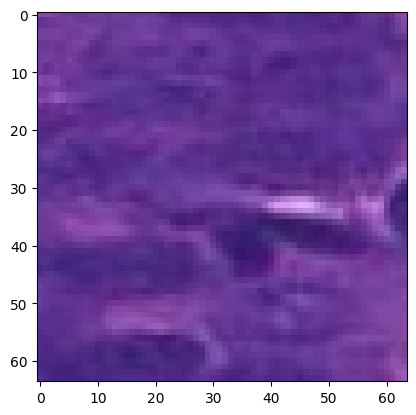

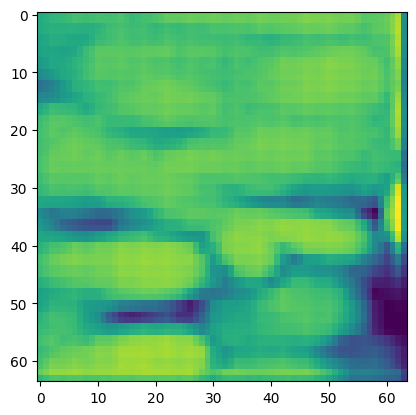

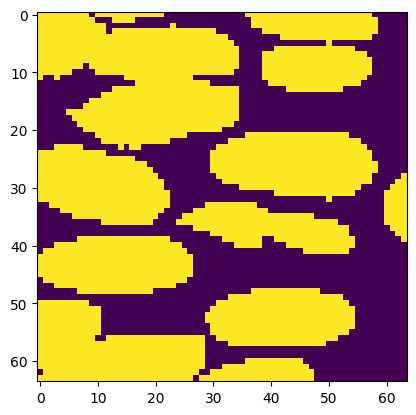

epoch 2/2, step 2510/3125, loss 33.807728958129886, acc 0.4122712016105652, time 2:46:04.161888
epoch 2/2, step 2520/3125, loss 34.594117164611816, acc 0.4240723252296448, time 2:46:21.537852
epoch 2/2, step 2530/3125, loss 33.82321968078613, acc 0.4414968490600586, time 2:46:38.712754
epoch 2/2, step 2540/3125, loss 32.73321743011475, acc 0.4290325343608856, time 2:46:56.132689
epoch 2/2, step 2550/3125, loss 32.974816131591794, acc 0.437984436750412, time 2:47:13.506329
epoch 2/2, step 2560/3125, loss 34.48760509490967, acc 0.3912849724292755, time 2:47:30.227884
epoch 2/2, step 2570/3125, loss 35.16806335449219, acc 0.49175405502319336, time 2:47:47.337911
epoch 2/2, step 2580/3125, loss 33.499647521972655, acc 0.43260207772254944, time 2:48:05.176211
epoch 2/2, step 2590/3125, loss 33.89686584472656, acc 0.41709110140800476, time 2:48:22.119802
epoch 2/2, step 2600/3125, loss 32.581964302062985, acc 0.4671127200126648, time 2:48:38.899667


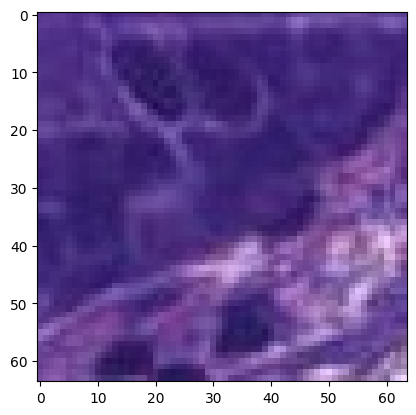

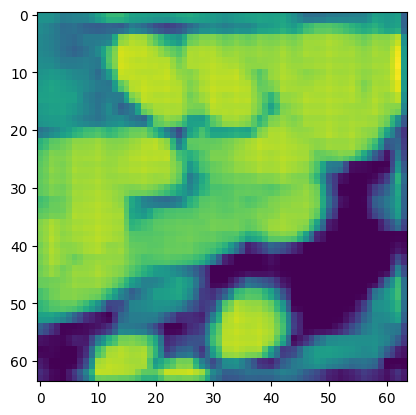

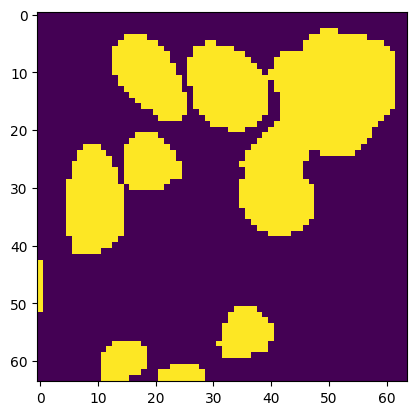

epoch 2/2, step 2610/3125, loss 34.57316665649414, acc 0.43553659319877625, time 2:48:56.926000
epoch 2/2, step 2620/3125, loss 34.857829856872556, acc 0.4675338566303253, time 2:49:13.880360
epoch 2/2, step 2630/3125, loss 35.702283477783205, acc 0.5031301379203796, time 2:49:31.244020
epoch 2/2, step 2640/3125, loss 33.885107803344724, acc 0.3982042074203491, time 2:49:48.520742
epoch 2/2, step 2650/3125, loss 33.18468399047852, acc 0.4016764760017395, time 2:50:05.412689
epoch 2/2, step 2660/3125, loss 35.48449554443359, acc 0.439207524061203, time 2:50:22.390463
epoch 2/2, step 2670/3125, loss 35.34839305877686, acc 0.46557027101516724, time 2:50:39.902651
epoch 2/2, step 2680/3125, loss 35.063031387329104, acc 0.45715805888175964, time 2:50:57.123104
epoch 2/2, step 2690/3125, loss 35.15238876342774, acc 0.47140780091285706, time 2:51:14.500807
epoch 2/2, step 2700/3125, loss 32.54499530792236, acc 0.4458068907260895, time 2:51:31.391497


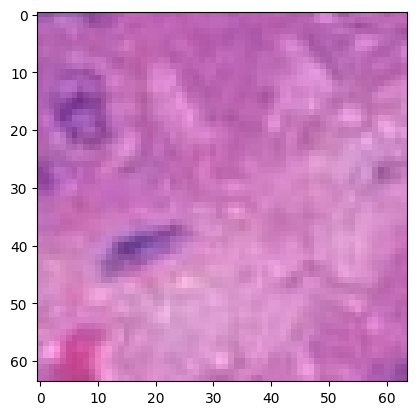

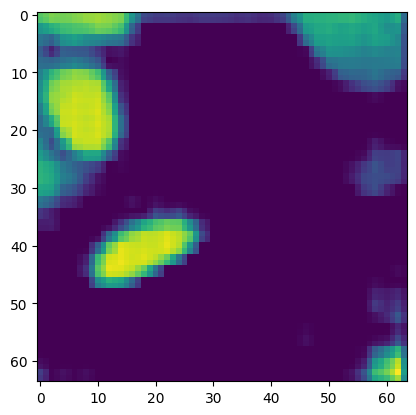

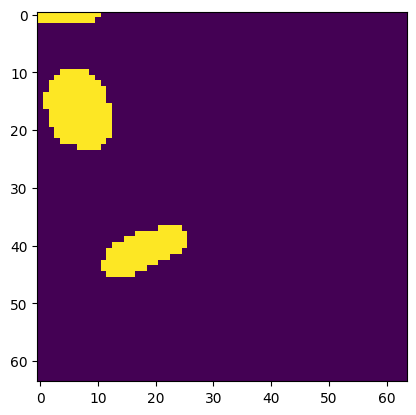

epoch 2/2, step 2710/3125, loss 31.92187786102295, acc 0.407702773809433, time 2:51:49.256467
epoch 2/2, step 2720/3125, loss 34.64579830169678, acc 0.4276125729084015, time 2:52:05.787332
epoch 2/2, step 2730/3125, loss 32.123439979553225, acc 0.38597404956817627, time 2:52:22.401559
epoch 2/2, step 2740/3125, loss 33.932549476623535, acc 0.42762070894241333, time 2:52:39.642598
epoch 2/2, step 2750/3125, loss 34.92808895111084, acc 0.4565267562866211, time 2:52:56.021399
epoch 2/2, step 2760/3125, loss 35.87060489654541, acc 0.4156832993030548, time 2:53:13.031598
epoch 2/2, step 2770/3125, loss 37.194418334960936, acc 0.4605511426925659, time 2:53:30.523833
epoch 2/2, step 2780/3125, loss 34.0491584777832, acc 0.38202720880508423, time 2:53:47.119434
epoch 2/2, step 2790/3125, loss 32.48387470245361, acc 0.4304802417755127, time 2:54:03.650335
epoch 2/2, step 2800/3125, loss 38.199059677124026, acc 0.4227937161922455, time 2:54:21.195342


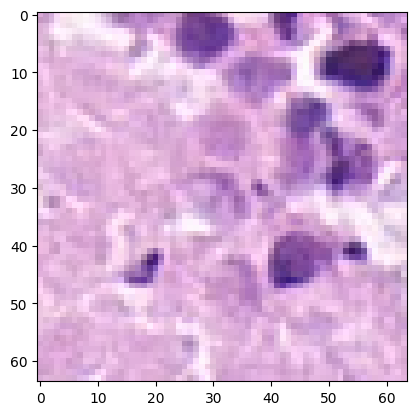

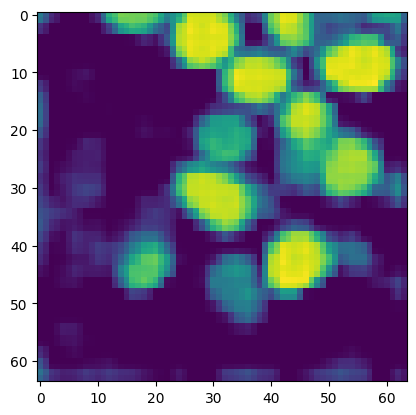

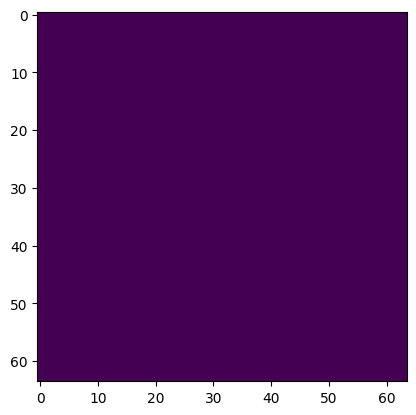

epoch 2/2, step 2810/3125, loss 36.09141616821289, acc 0.4717082381248474, time 2:54:38.183919
epoch 2/2, step 2820/3125, loss 32.23789958953857, acc 0.40758606791496277, time 2:54:55.362560
epoch 2/2, step 2830/3125, loss 32.97326526641846, acc 0.44571325182914734, time 2:55:12.367109
epoch 2/2, step 2840/3125, loss 34.42399559020996, acc 0.43960803747177124, time 2:55:29.319724
epoch 2/2, step 2850/3125, loss 36.049567794799806, acc 0.4300466477870941, time 2:55:46.123300
epoch 2/2, step 2860/3125, loss 35.14285469055176, acc 0.3958292007446289, time 2:56:02.844740
epoch 2/2, step 2870/3125, loss 34.4328311920166, acc 0.4332467019557953, time 2:56:19.706611
epoch 2/2, step 2880/3125, loss 34.55857963562012, acc 0.4502514600753784, time 2:56:36.925686
epoch 2/2, step 2890/3125, loss 34.732793998718265, acc 0.4165440499782562, time 2:56:54.020271
epoch 2/2, step 2900/3125, loss 36.407196044921875, acc 0.3858584463596344, time 2:57:10.566664


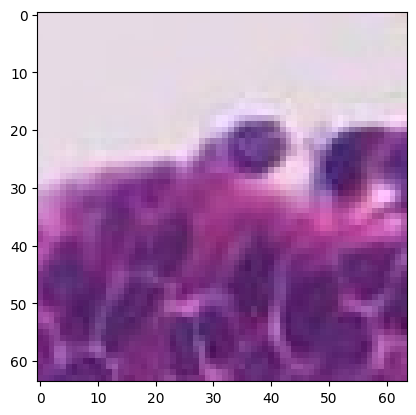

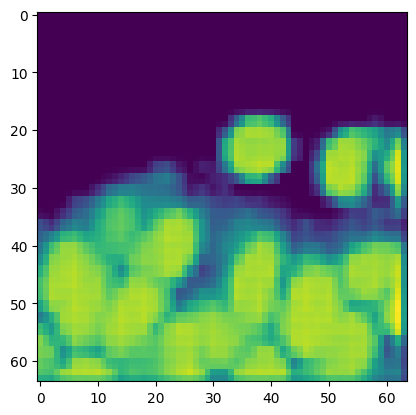

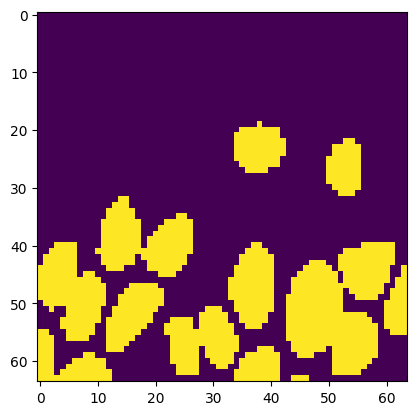

epoch 2/2, step 2910/3125, loss 33.94036312103272, acc 0.42742639780044556, time 2:57:28.105469
epoch 2/2, step 2920/3125, loss 35.27140655517578, acc 0.47222745418548584, time 2:57:44.895270
epoch 2/2, step 2930/3125, loss 32.76673221588135, acc 0.4116995930671692, time 2:58:01.151574
epoch 2/2, step 2940/3125, loss 33.89627056121826, acc 0.4441109597682953, time 2:58:18.088372
epoch 2/2, step 2950/3125, loss 33.33375835418701, acc 0.39074331521987915, time 2:58:37.310862
epoch 2/2, step 2960/3125, loss 36.0363265991211, acc 0.4443352222442627, time 2:58:56.068633
epoch 2/2, step 2970/3125, loss 33.45886287689209, acc 0.4607071578502655, time 2:59:13.150481
epoch 2/2, step 2980/3125, loss 33.11566696166992, acc 0.4246257245540619, time 2:59:29.536071
epoch 2/2, step 2990/3125, loss 33.47722454071045, acc 0.4100364148616791, time 2:59:46.389968
epoch 2/2, step 3000/3125, loss 35.103895378112796, acc 0.4849819540977478, time 3:00:03.482900


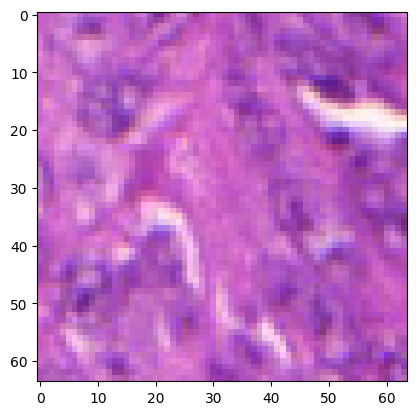

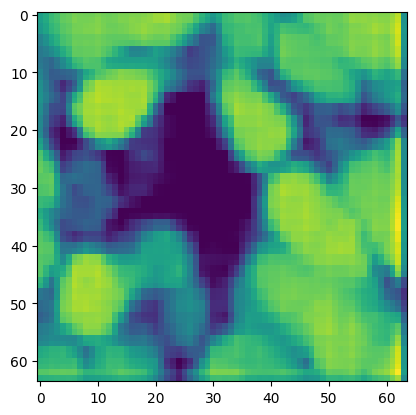

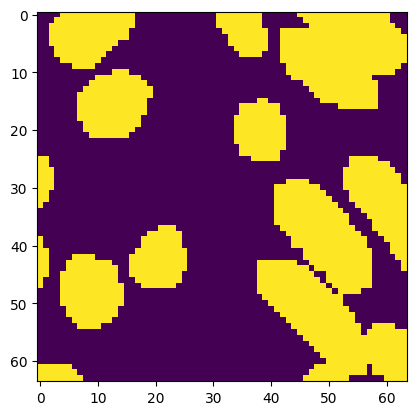

epoch 2/2, step 3010/3125, loss 35.498583984375, acc 0.42521995306015015, time 3:00:20.505000
epoch 2/2, step 3020/3125, loss 32.53438396453858, acc 0.44848620891571045, time 3:00:36.990396
epoch 2/2, step 3030/3125, loss 31.83186321258545, acc 0.4511375427246094, time 3:00:54.840100
epoch 2/2, step 3040/3125, loss 33.820810317993164, acc 0.45669734477996826, time 3:01:11.958534
epoch 2/2, step 3050/3125, loss 36.36923408508301, acc 0.4556271731853485, time 3:01:31.892369
epoch 2/2, step 3060/3125, loss 33.893021965026854, acc 0.4026365578174591, time 3:02:01.464844
epoch 2/2, step 3070/3125, loss 33.163968086242676, acc 0.44979313015937805, time 3:02:33.509526
epoch 2/2, step 3080/3125, loss 33.71676521301269, acc 0.42495983839035034, time 3:03:14.580854
epoch 2/2, step 3090/3125, loss 34.623844146728516, acc 0.4128953814506531, time 3:04:00.937044
epoch 2/2, step 3100/3125, loss 34.63780975341797, acc 0.40223366022109985, time 3:04:32.481985


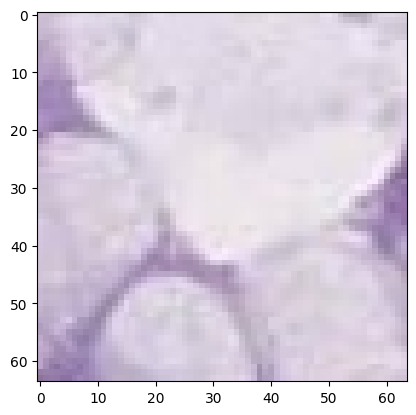

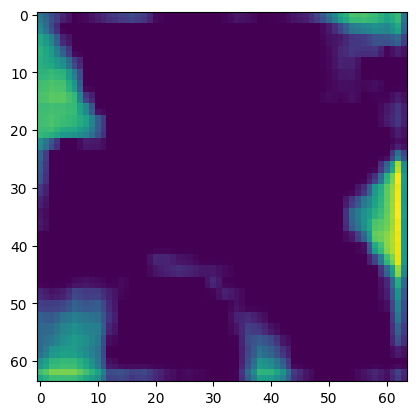

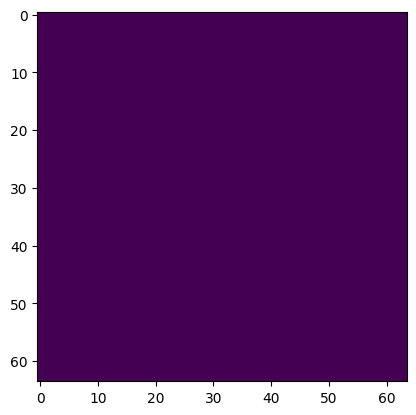

epoch 2/2, step 3110/3125, loss 34.6322114944458, acc 0.44254833459854126, time 3:05:03.324310
epoch 2/2, step 3120/3125, loss 33.501907157897946, acc 0.4108234643936157, time 3:05:38.214310


In [13]:
start_time = datetime.now()
for epoch in range(num_epochs):
    avg_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        opt.zero_grad()
        outputs = net(inputs.float())
        loss = loss_fn(outputs.squeeze(1), labels.float())
        
        loss.backward()
        opt.step()
        acc = dice(outputs, labels)
        wandb.log({"loss_2": loss})
        wandb.log({"acc_2": acc})
        avg_loss += loss.item()
        if (i+1) % 10 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {avg_loss/10}, acc {acc}, time {(datetime.now()-start_time)}')
            avg_loss = 0
        if (i+1) % 100 == 0:
            plt.imshow(inputs[0].permute((1, 2, 0)).detach().numpy()/255)
            plt.show()
            plt.imshow(outputs[0][0].detach().numpy())
            plt.show()
            plt.imshow(labels[0].detach().numpy())
            plt.show()

In [14]:
torch.save(net, "unet_cross_adam_001_64_2")

In [8]:
net = UNET(3, 1)
net = torch.load("unet_cross_adam_001_64_1")
# net24 - CrossEntropy

In [9]:
dataloader_test = DataLoader(dataset=test_data, batch_size=64, shuffle=True)
total_dice = 0
total_samples = len(test_data)
n_iterations = math.ceil(total_samples/64)
with torch.no_grad():
    for i, (features, labels) in enumerate(dataloader_test):
        outputs = net(features.float())
        total_dice += dice(outputs, labels)
        if i % 100 == 0:
            print(f'step {i} from {n_iterations}')
print(f'avg dice score: {total_dice / n_iterations}')

step 0 from 689
step 100 from 689
step 200 from 689
step 300 from 689
step 400 from 689
step 500 from 689
step 600 from 689
avg dice score: 0.4378494620323181


tensor(0.4319)


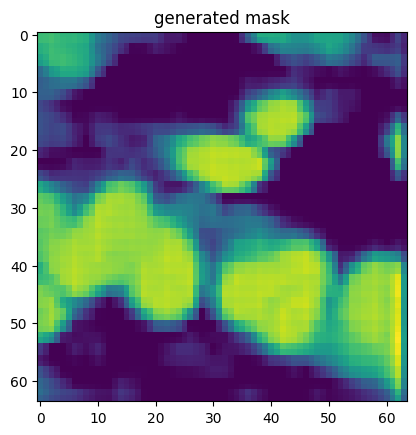

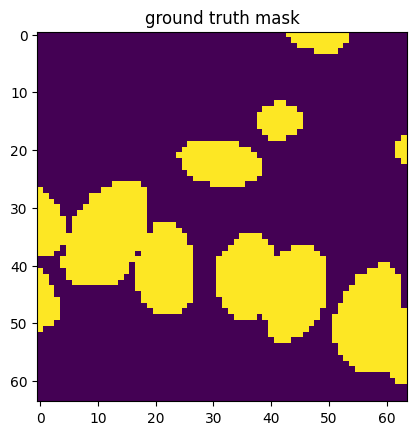

In [11]:
dataloader_test = DataLoader(dataset=test_data, batch_size=1, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)
features, labels = data
with torch.no_grad():
    outputs = net(features.float())
    print(dice(outputs, labels))
    plt.imshow(outputs[0][0].detach().numpy())
    plt.title("generated mask")
    plt.show()
    plt.imshow(labels[0].detach().numpy())
    plt.title("ground truth mask")
    plt.show()

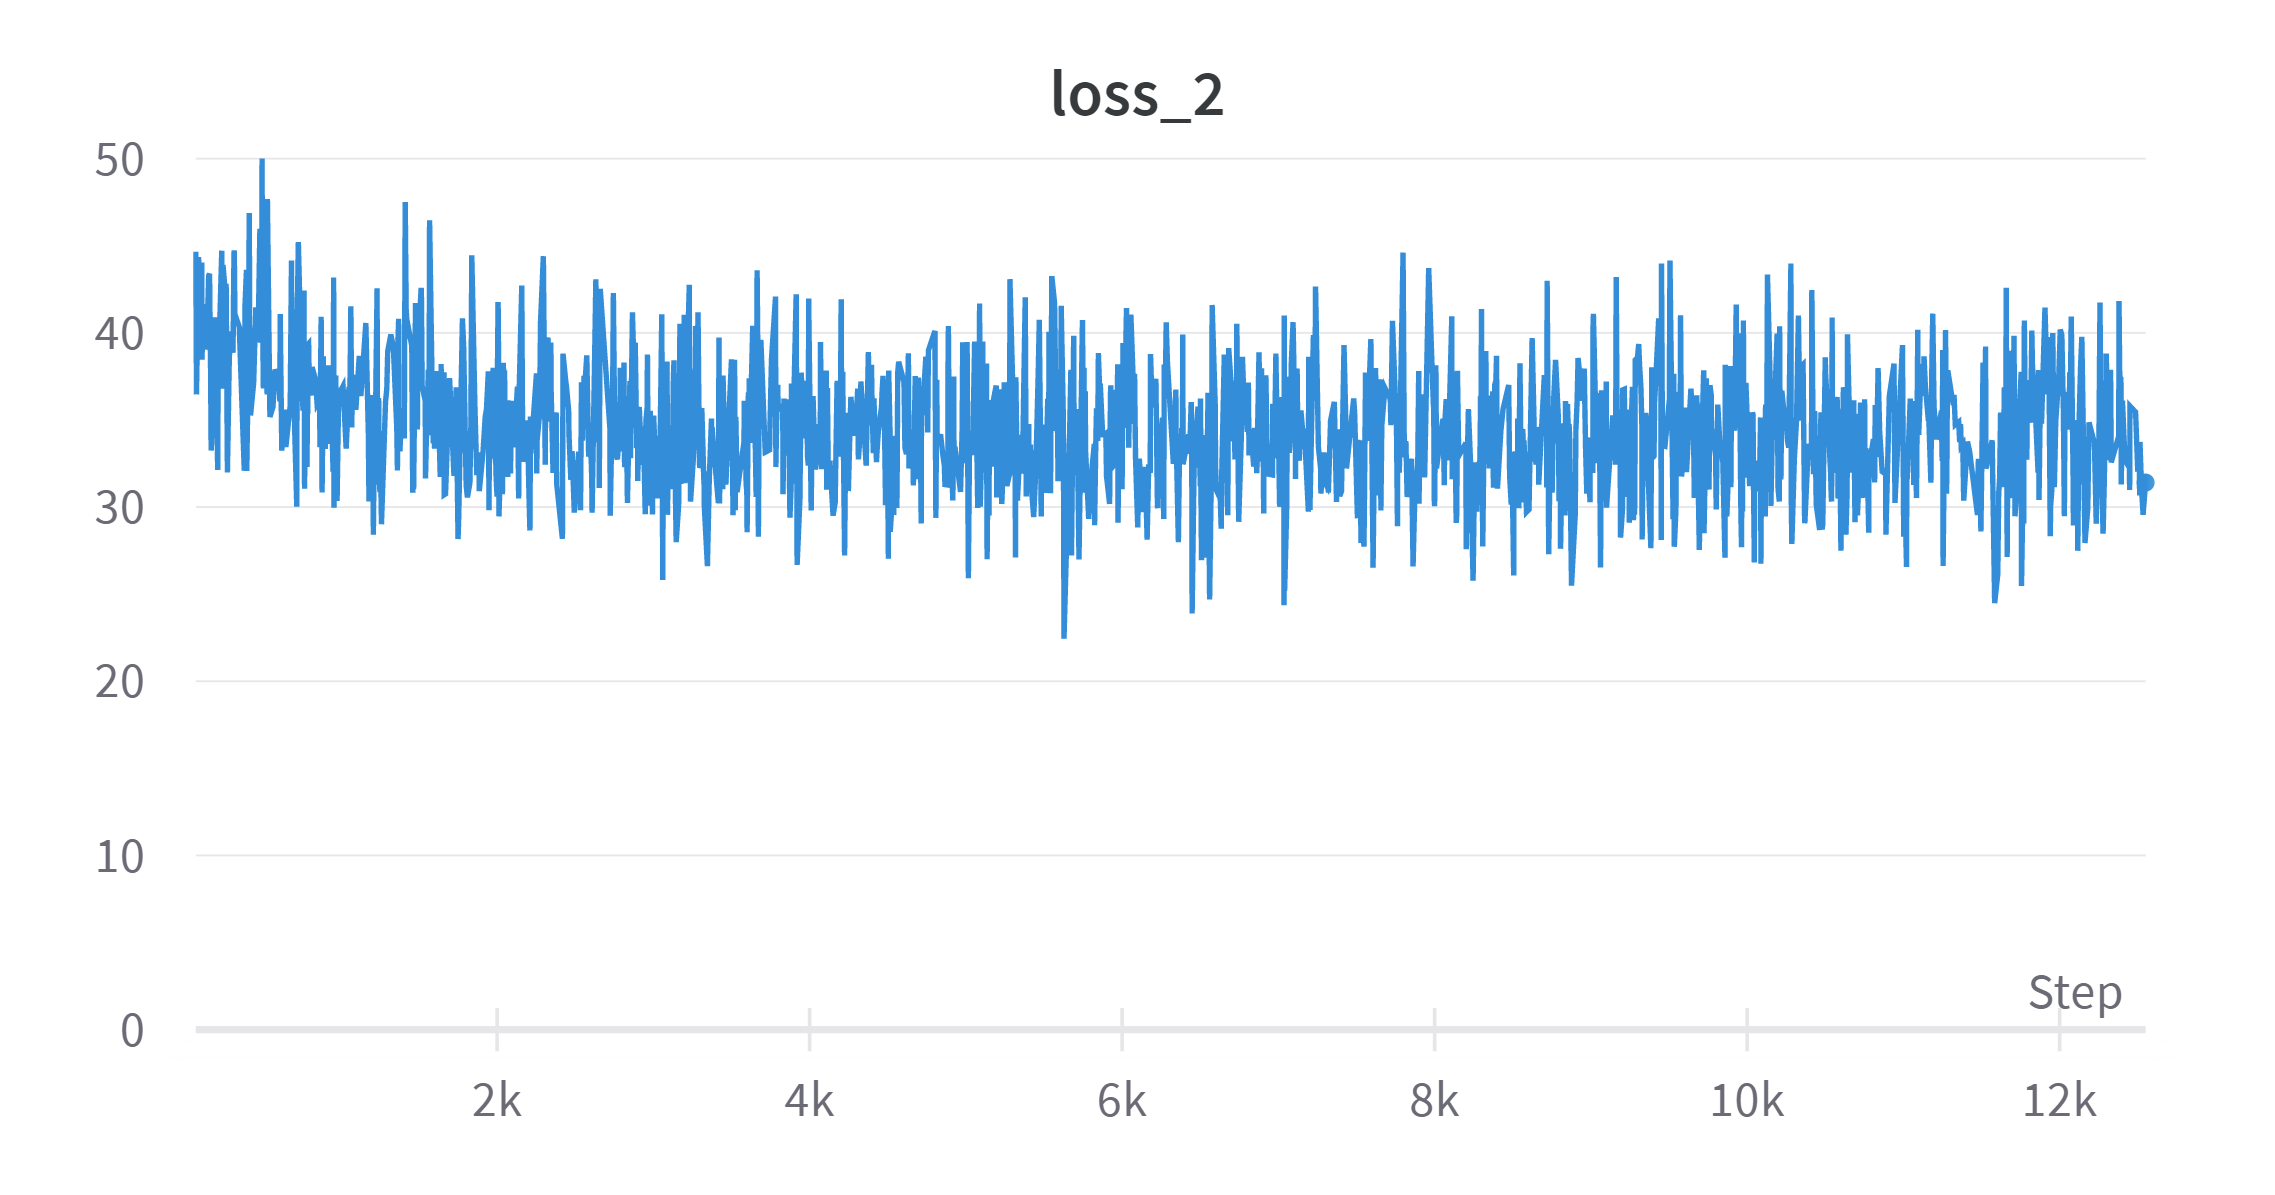

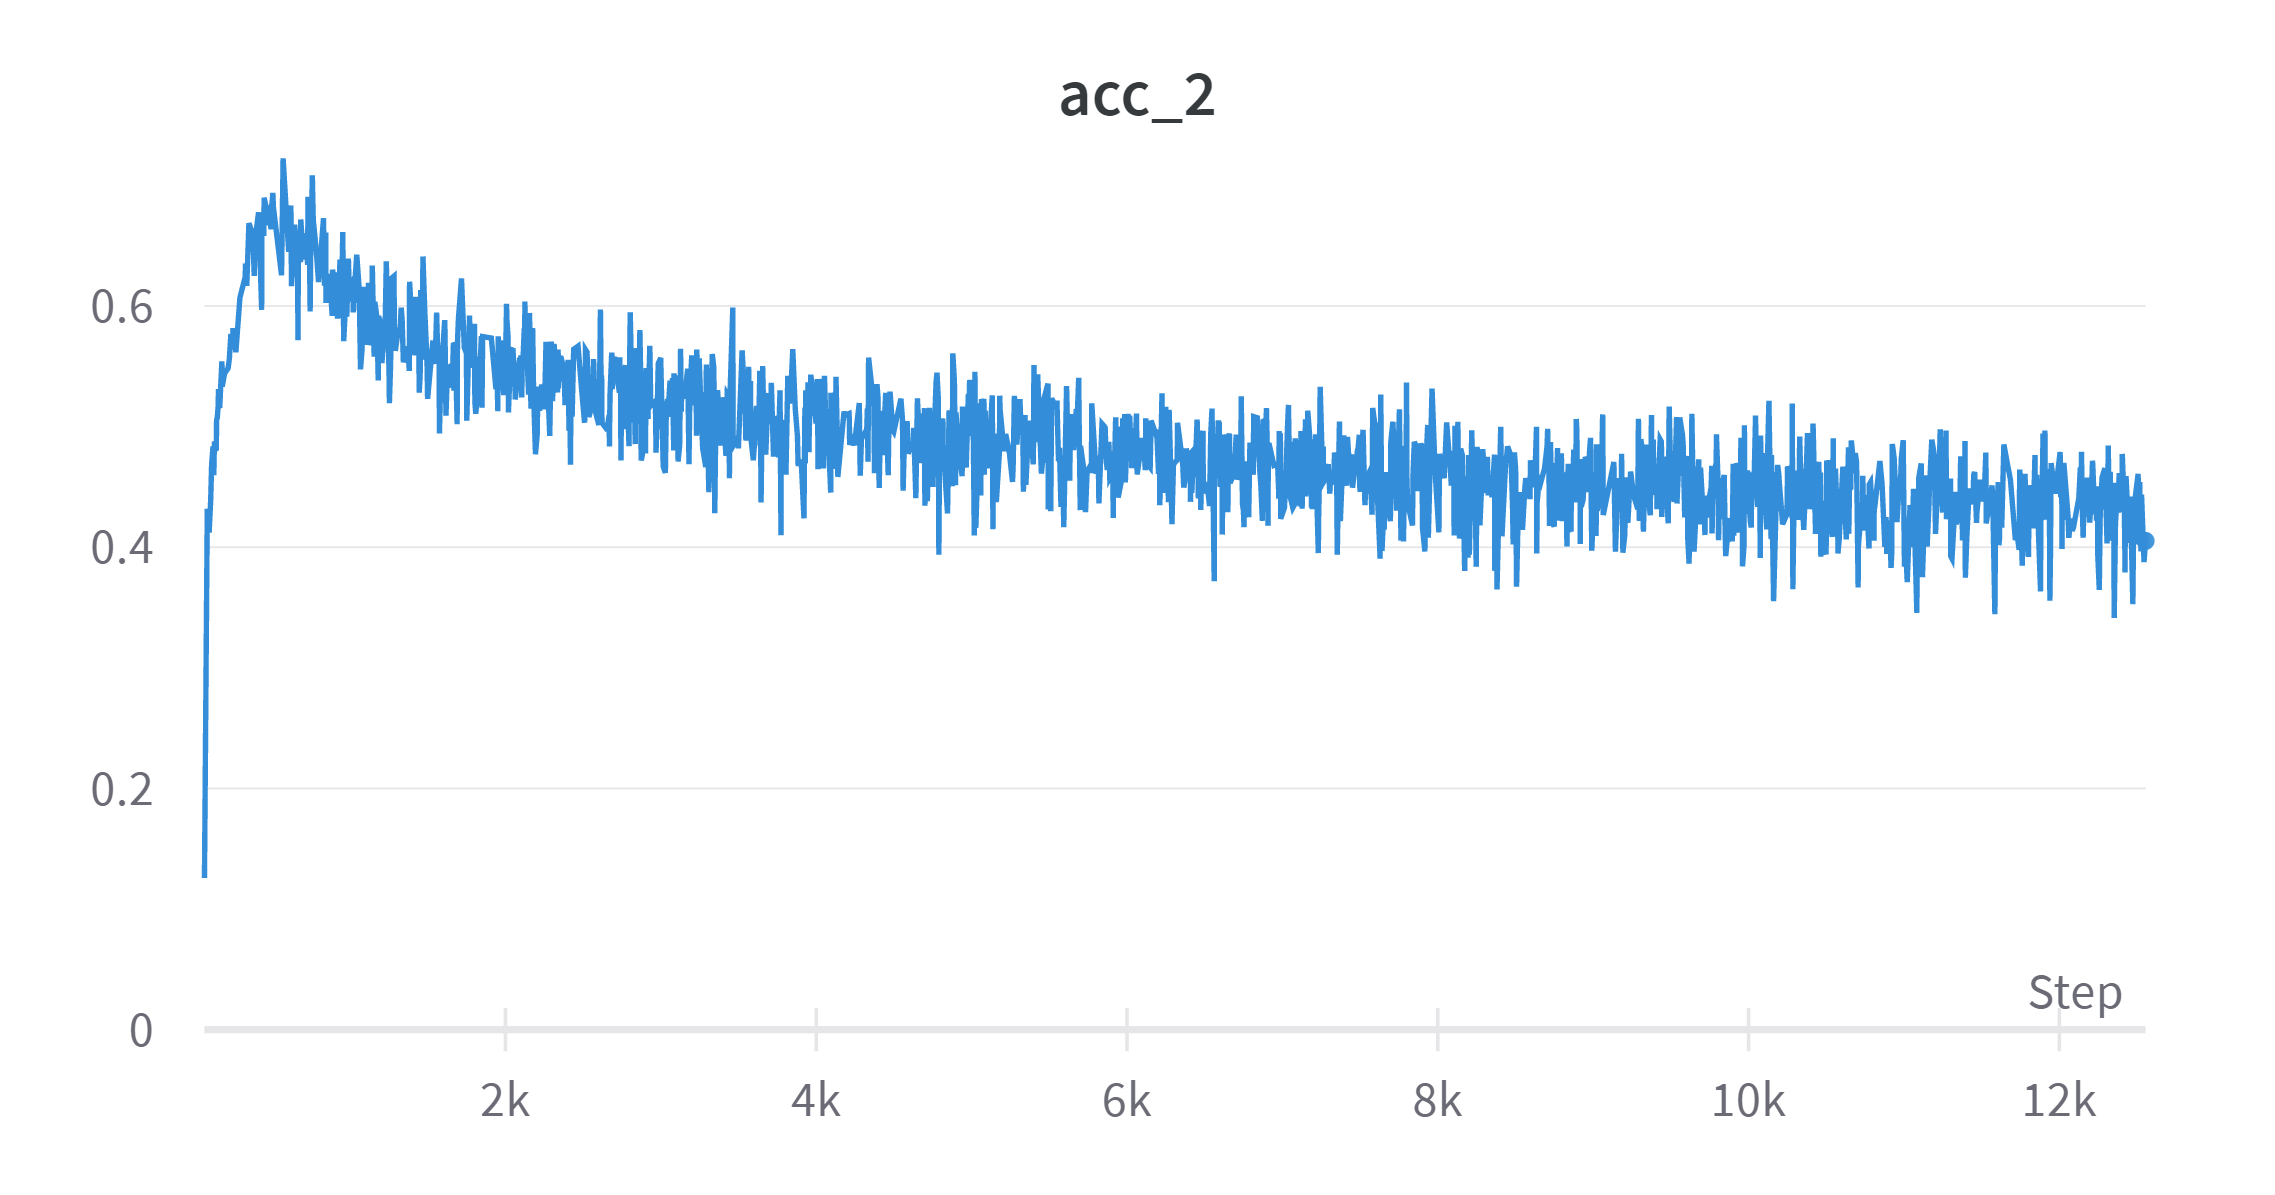

epoch 2/2, step 3120/3125, loss 33.501907157897946, acc 0.4108234643936157, time 3:05:38.214310

avg test dice score: 0.4378494620323181

CrossEntropyLoss, Adam at 0.001, Dice score (acc)

batch 64